In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter
from matplotlib import colors
from spatialentropy import altieri_entropy
from datetime import date
import time
import sys
from fears.population import Population
sys.path.append("./utils")
from DoseResponseModel import DoseResponseModel

In [42]:
p = Population(death_model = None,n_allele=2,fitness_data='random')
p.drugless_rates = [1.28949852, 1.14399848, 1.22802236, 0.93619847]
p.ic50 = [-0.49205992, 1.76224515,  1.39341393,  2.84653598]

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

def get_most_fit_at_conc(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        for j in range(data.shape[1]):
            # conc = 10**data[z,j]
            conc = data[z,j]
            p_fit_list = p.gen_fit_land(conc)
            most_fit_at_conc[z,j] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

def estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False):
    msw_entropy = []
    pop_entropy = []
    msw_count = []
    pop_count = []
    # consumpt_rate_list = []
    for i,rate in enumerate(consumpt_rate):
        dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
        diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
        diffGrid = pd.read_csv(diffGridFile)
        msw_list = get_most_fit_at_conc_1d(np.array(diffGrid['field']))
        msw_list = np.array(msw_list, dtype=int)
        points = np.array(diffGrid[['x','y']])
        e_msw = altieri_entropy(points, msw_list)
        
        for j in range(n_replicates):
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
            popGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
            popGrid = pd.read_csv(popGridFile)
            points = np.array(popGrid[['x','y']])
            types = np.array(popGrid['genotype'])
            e_pop = altieri_entropy(points, types)
            pop_entropy.append(e_pop.entropy)
            msw_entropy.append(e_msw.entropy)
            # consumpt_rate_list.append(rate)
            for g in range(4):
                msw_count.append(np.sum(msw_list==g))
                pop_count.append(np.sum(types==g))

            if debug and j == 0:
                # plot exemplary sims
                fig,ax_list = plt.subplots(ncols=2,figsize=(10,5))
                msw_img = np.zeros((100,100))
                pop_img = np.zeros((100,100))
                for index,row in popGrid.iterrows():
                    x,y = row['x'],row['y']
                    pop_img[int(row['x']),int(row['y'])] = row['genotype']
                for index,row in diffGrid.iterrows():
                    if row['field'] > 0:
                        msw_img[int(row['x']),int(row['y'])] = row['field']
                msw_img = get_most_fit_at_conc(msw_img)
                cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
                cc_dict = cc.by_key()
                c = cc_dict['color']

                indx = list(set(msw_img.flatten()))
                indx = [int(i) for i in indx]
                c = [c[i] for i in indx]

                cmap = colors.ListedColormap(c)
                ax_list[0].imshow(msw_img,cmap=cmap)
                ax_list[1].imshow(pop_img,cmap=cmap)

    # compute correlation
    msw_entropy = np.array(msw_entropy)
    pop_entropy = np.array(pop_entropy)
    msw_count = np.array(msw_count)
    pop_count = np.array(pop_count)
    # entropy_res = stats.linregress(msw_entropy,pop_entropy)
    square_deviation = np.sum((msw_entropy-pop_entropy)**2)/np.sum(msw_entropy)
    nonzero_indx = np.logical_and(msw_count>0,pop_count>0)
    area_res = stats.linregress(np.log(msw_count[nonzero_indx]),np.log(pop_count[nonzero_indx]))
    # return entropy_res, area_res
    if debug:
        fig,ax_list = plt.subplots(ncols=2)
        ax = ax_list[0]
        ax.scatter(np.log(msw_count[nonzero_indx]),np.log(pop_count[nonzero_indx]))
        ax.plot(np.log(msw_count[nonzero_indx]),area_res.slope*np.log(msw_count[nonzero_indx])+area_res.intercept)
        ax.set_xlabel('log(MSW count)')
        ax.set_ylabel('log(Population count)')
        ax = ax_list[1]
        ax.scatter(msw_entropy,pop_entropy)
        # ax.plot(msw_entropy,entropy_res.slope*msw_entropy+entropy_res.intercept)
        ax.set_xlabel('MSW entropy')
        ax.set_ylabel('Population entropy')
        fig.tight_layout()
    return area_res, square_deviation

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_90085/2281477465.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax_list = plt.subplots(ncols=2)


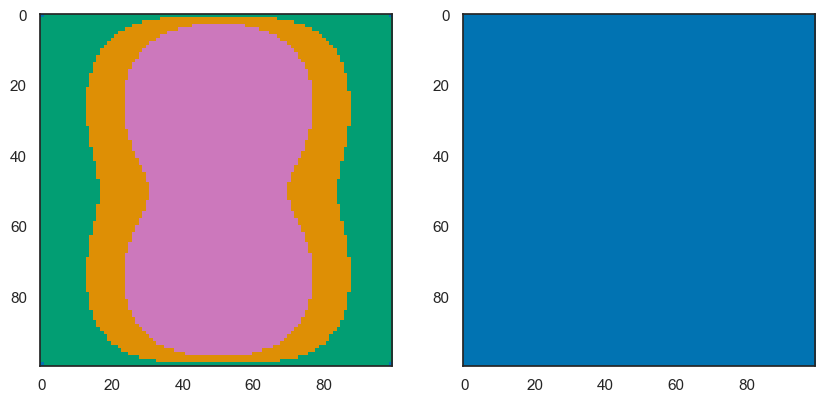

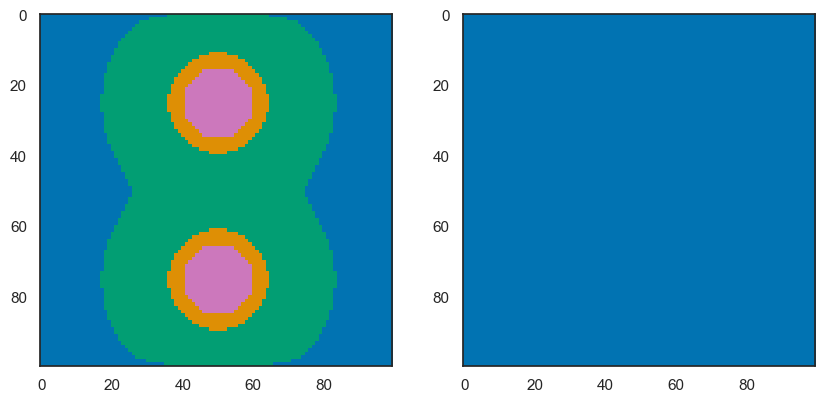

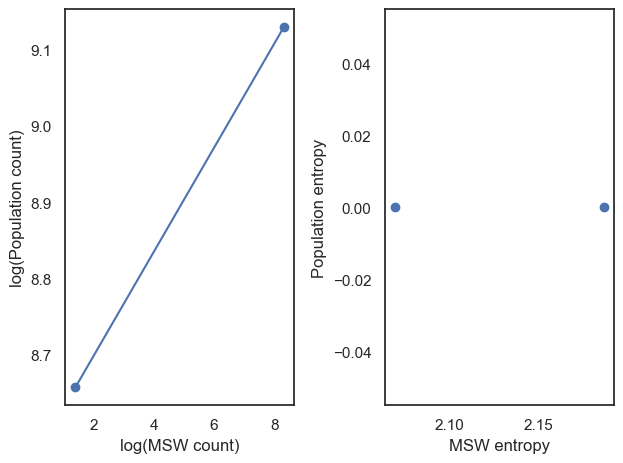

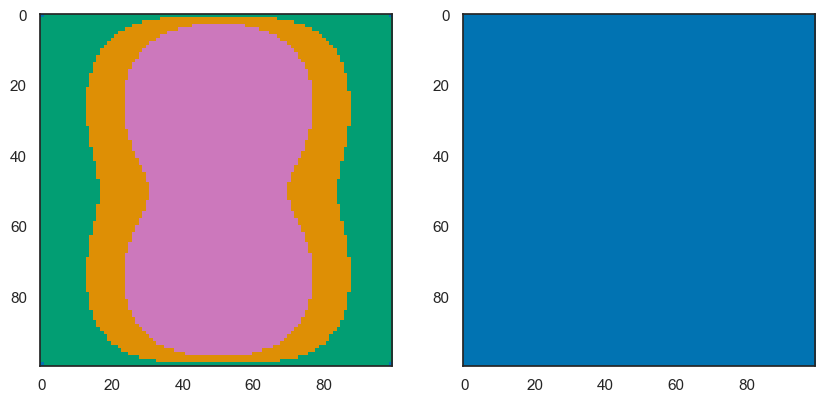

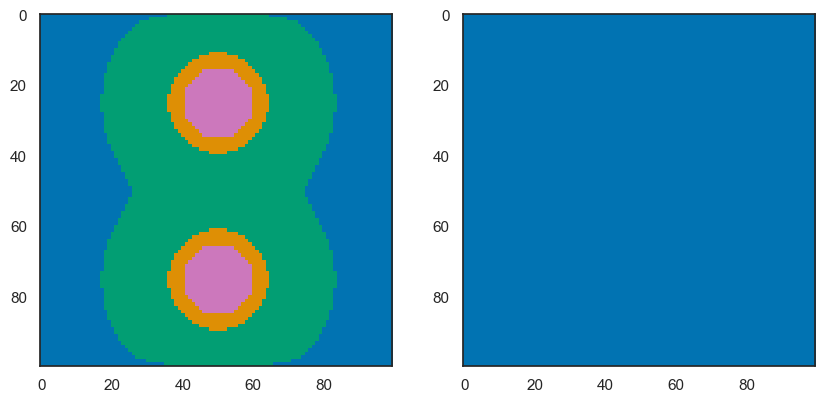

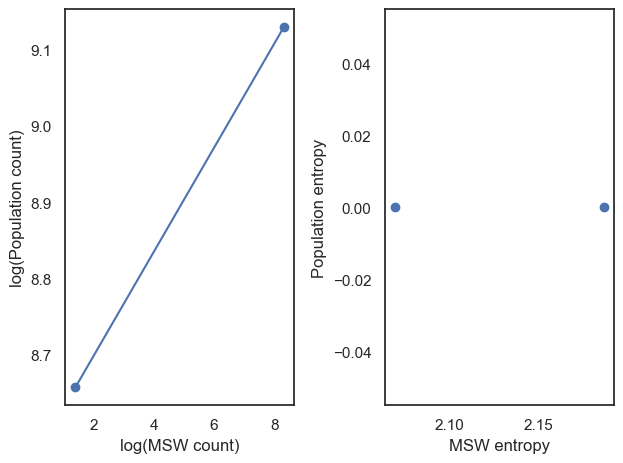

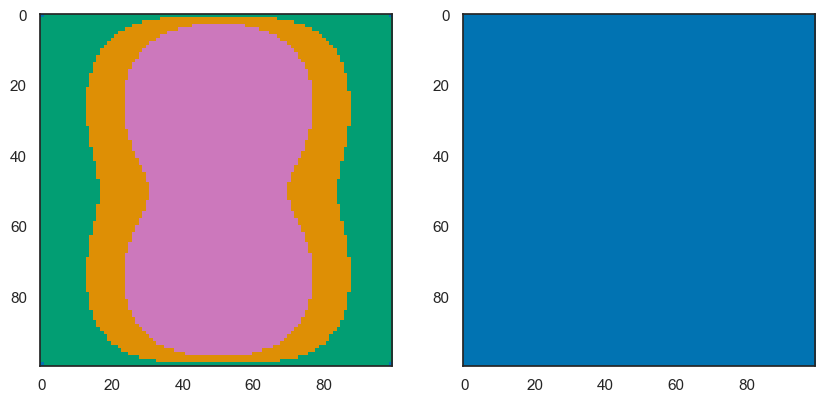

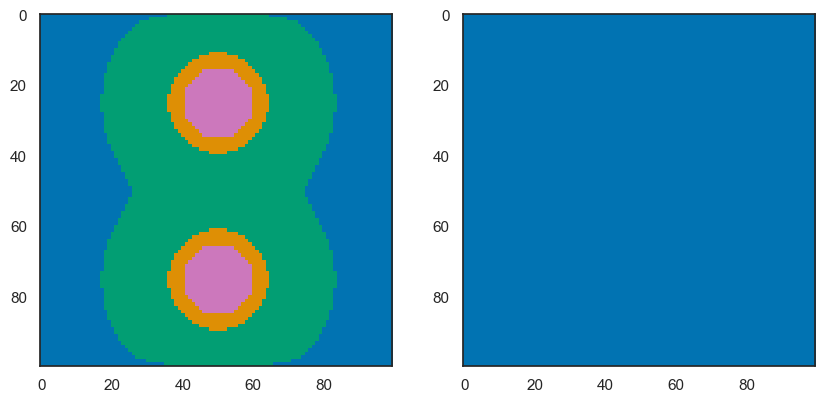

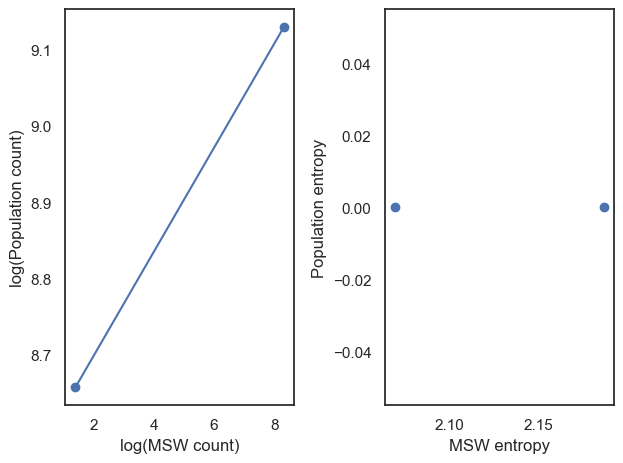

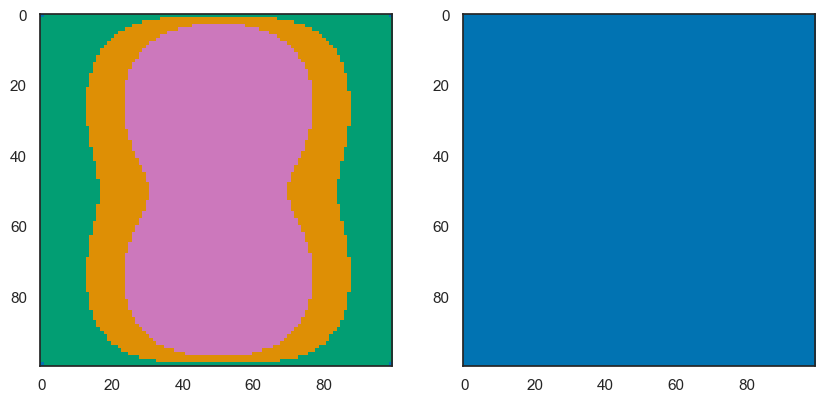

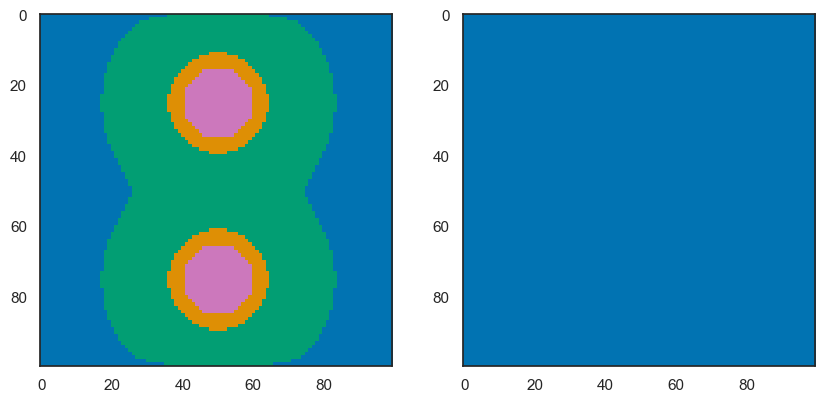

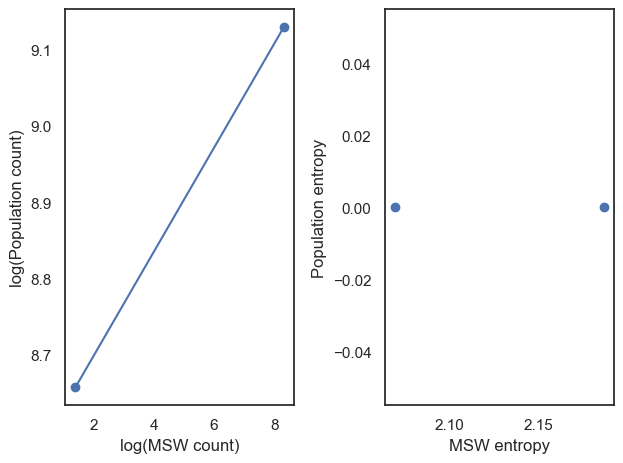

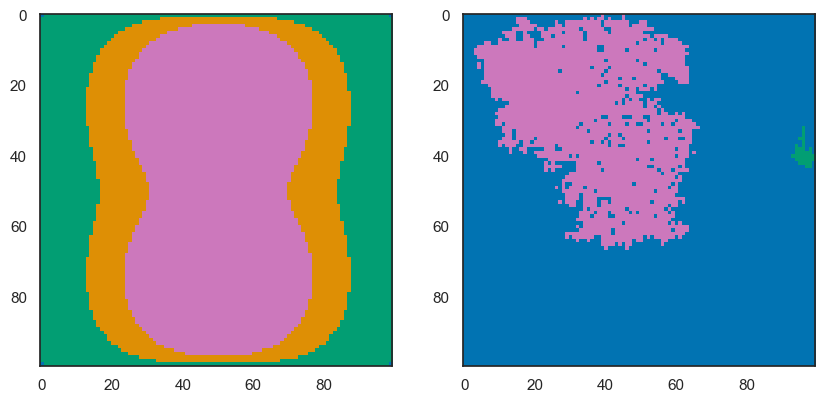

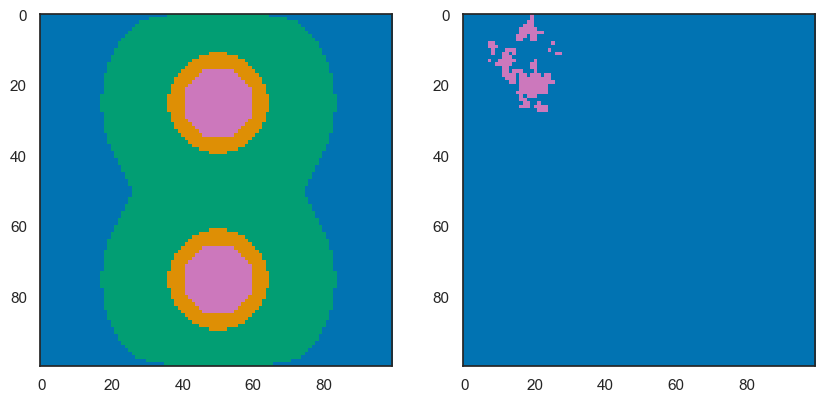

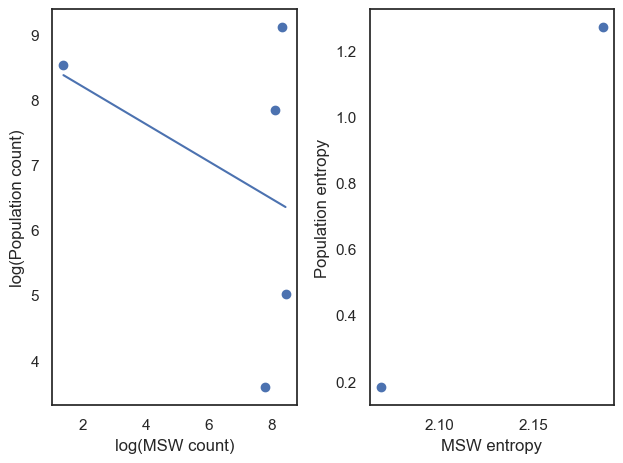

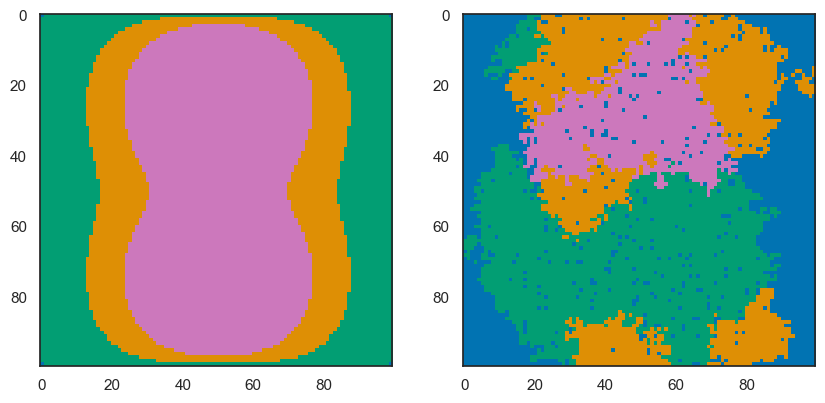

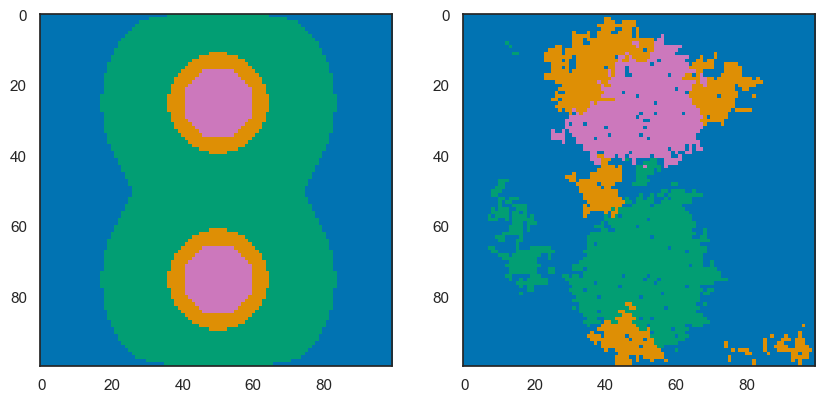

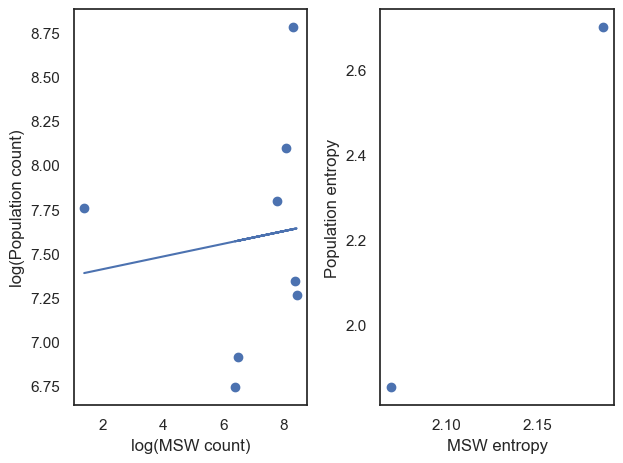

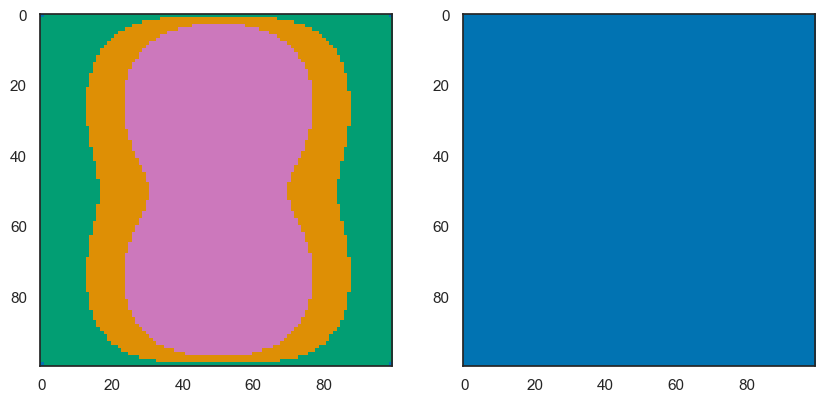

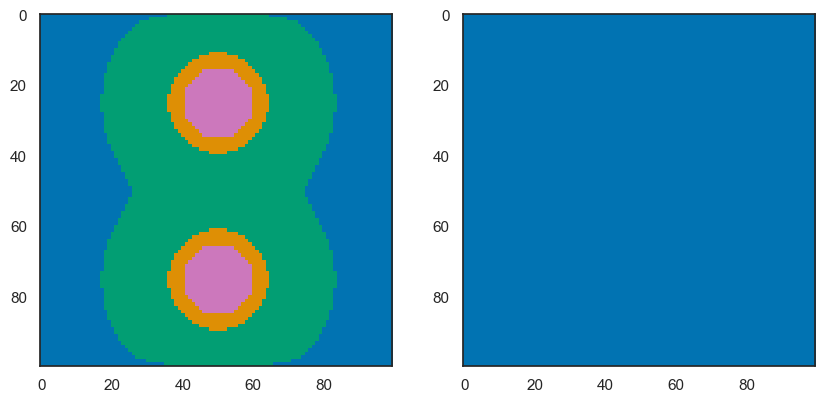

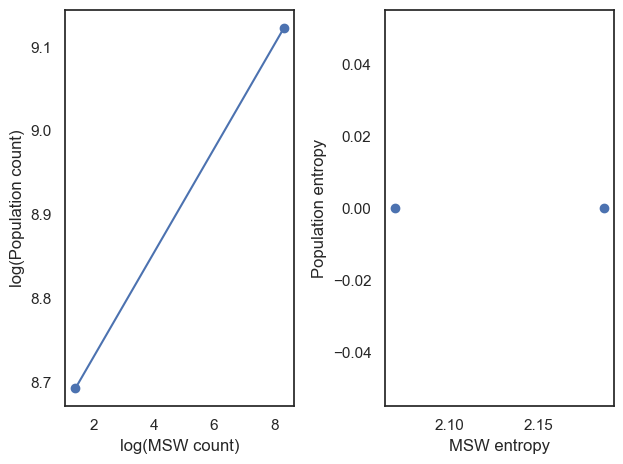

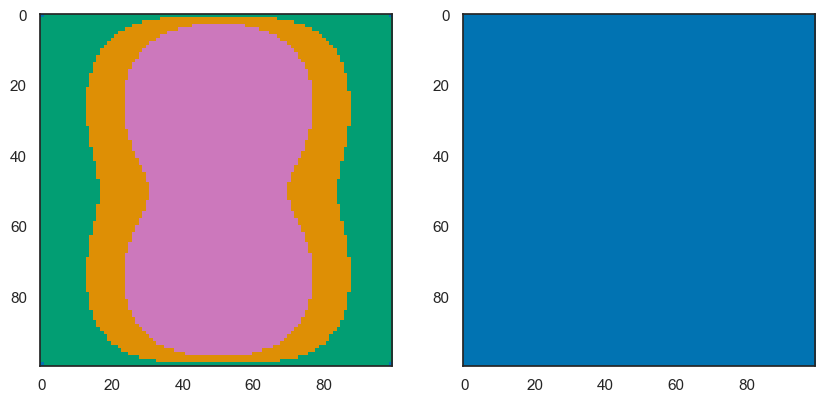

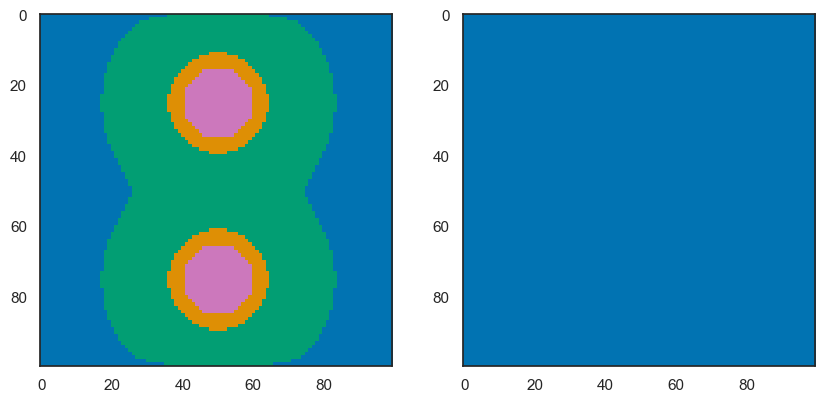

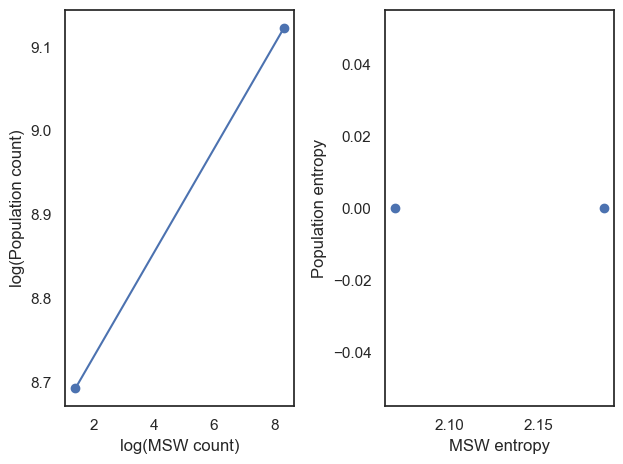

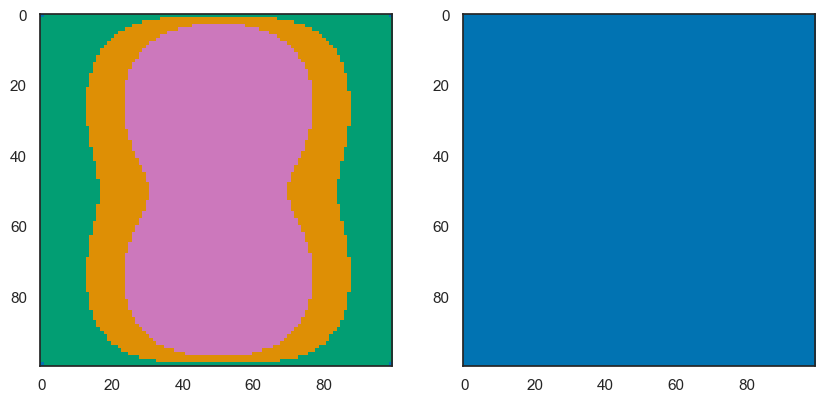

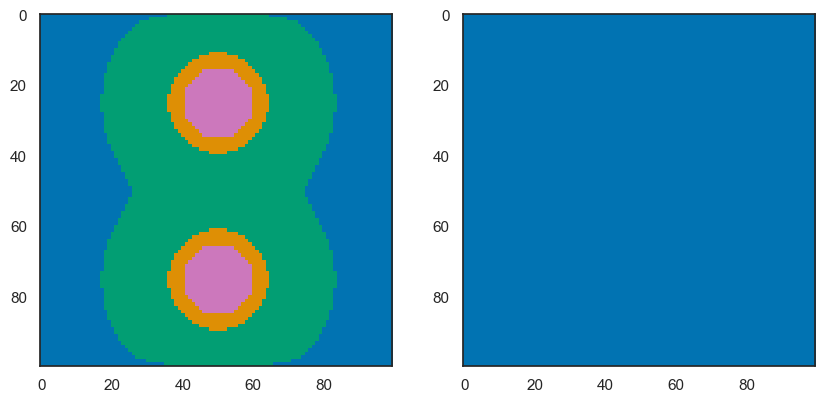

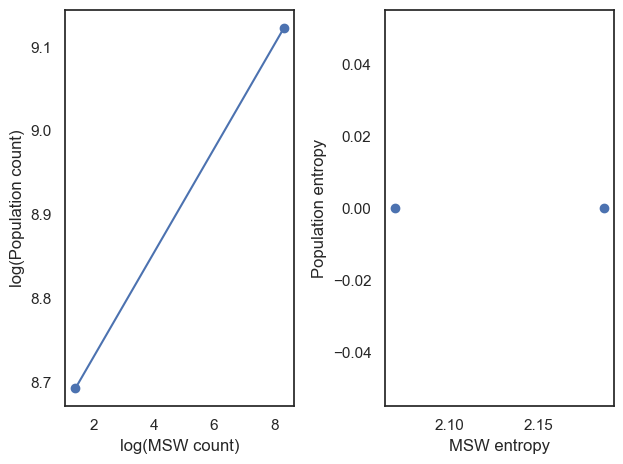

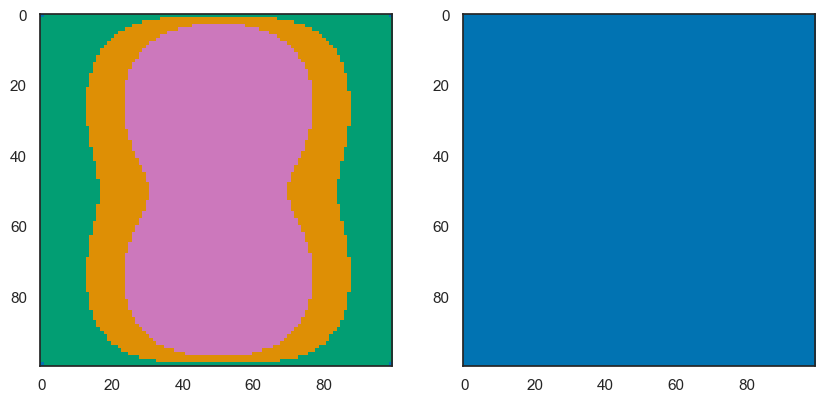

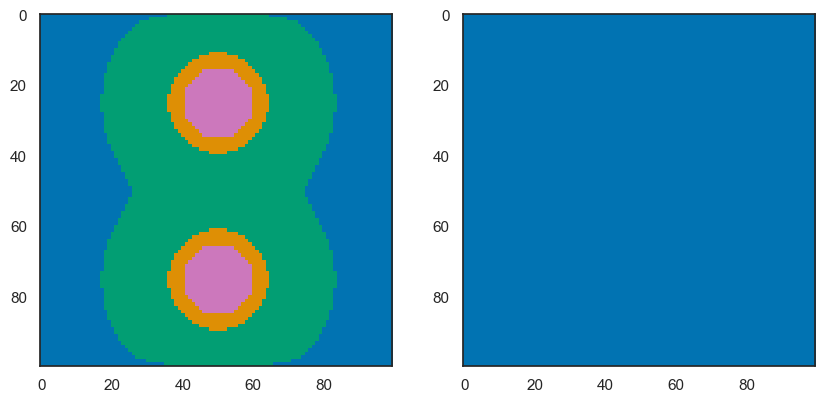

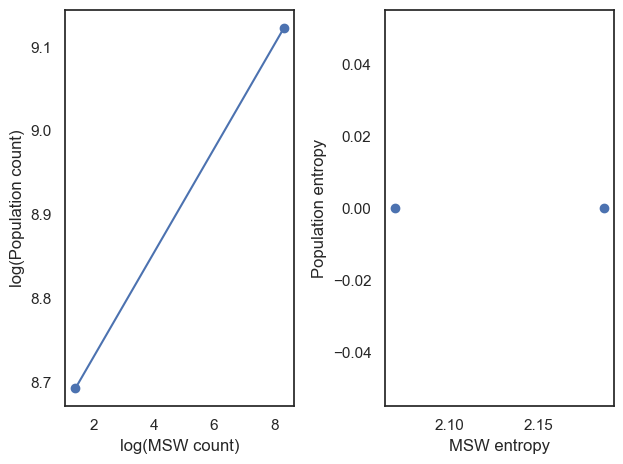

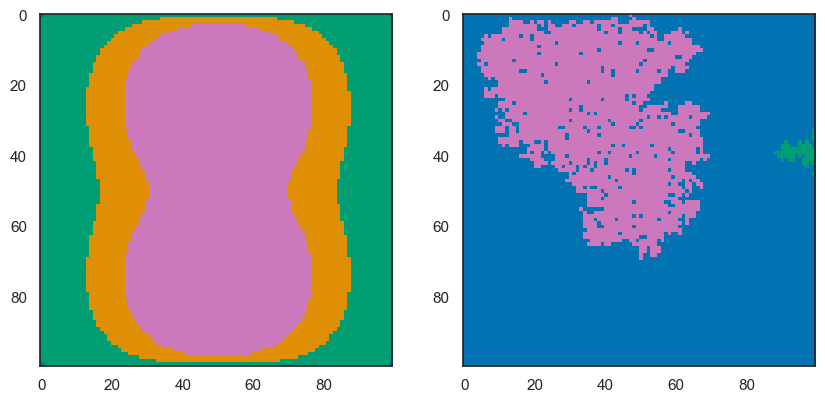

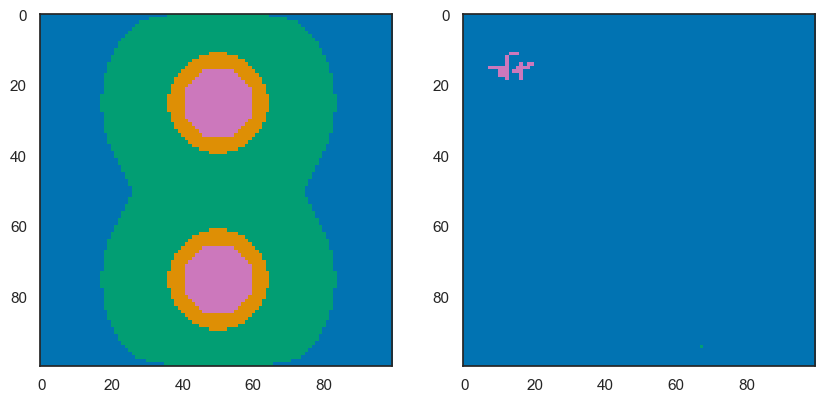

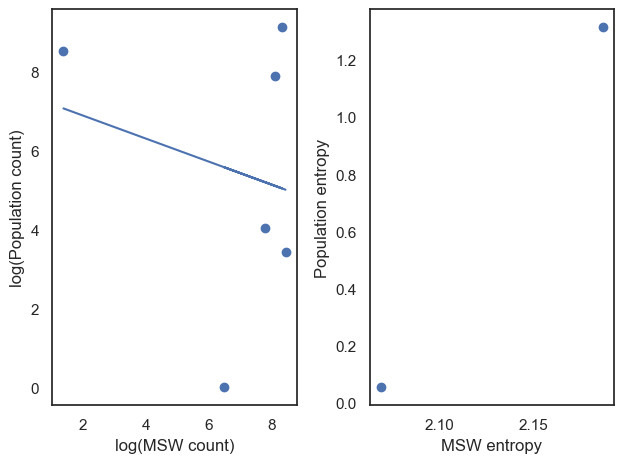

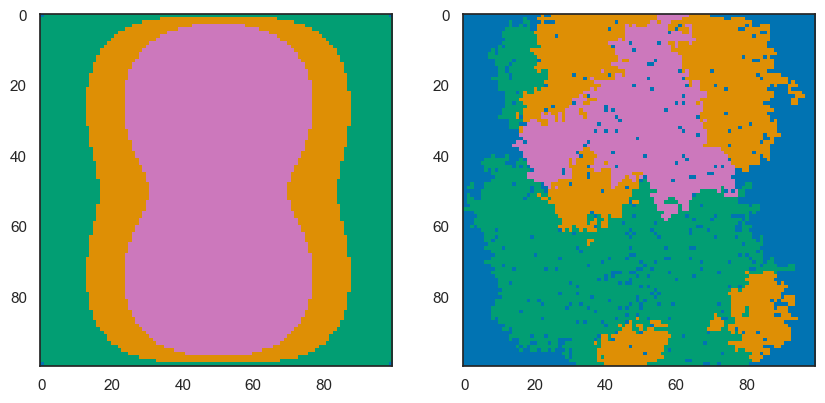

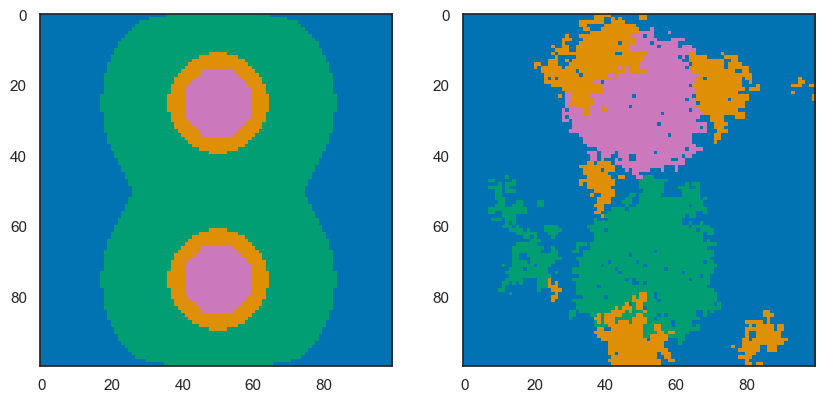

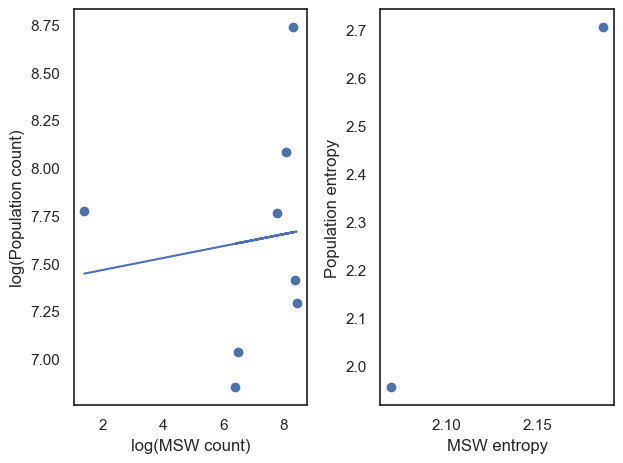

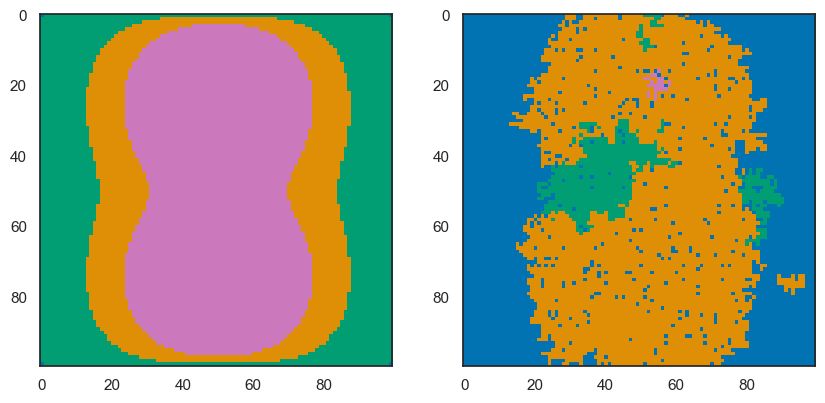

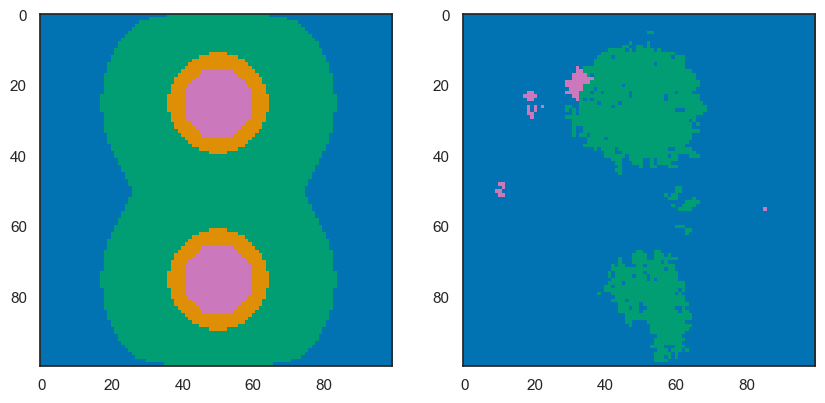

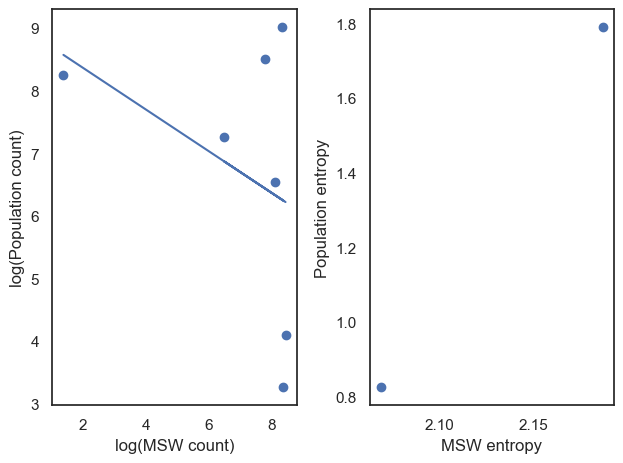

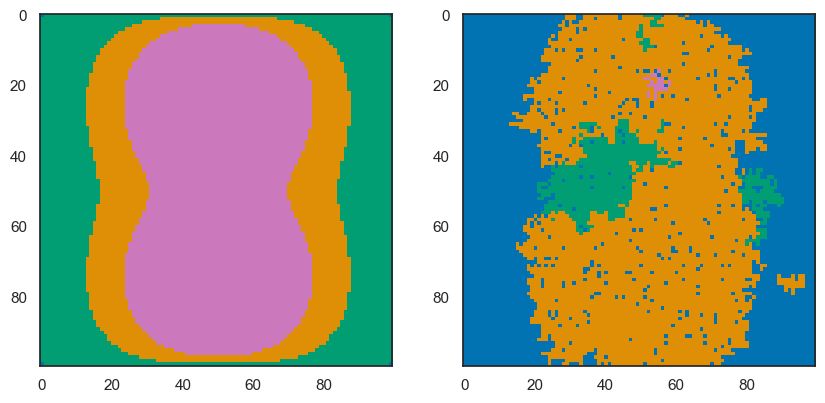

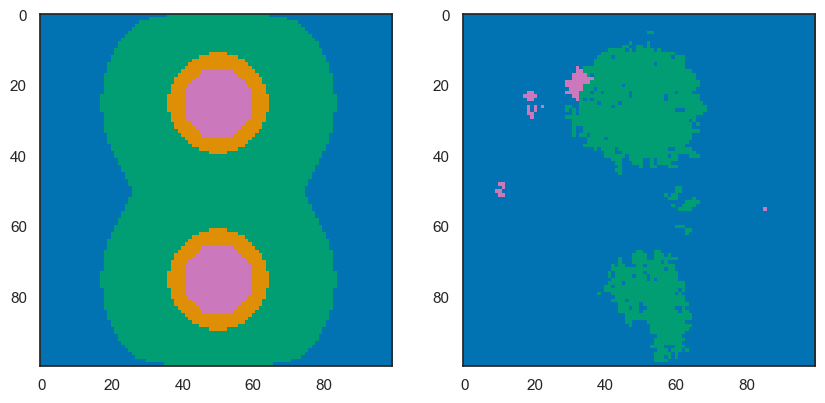

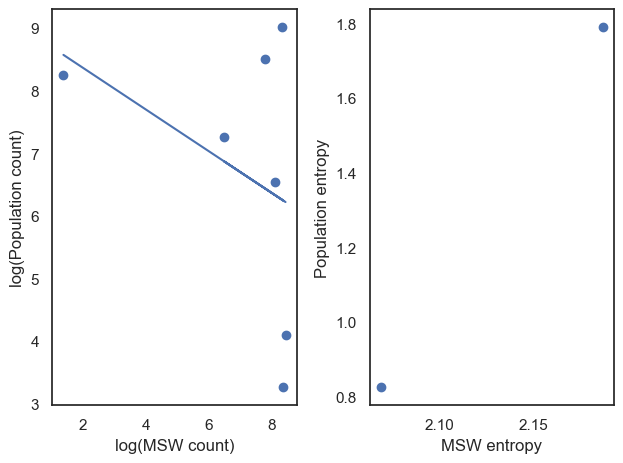

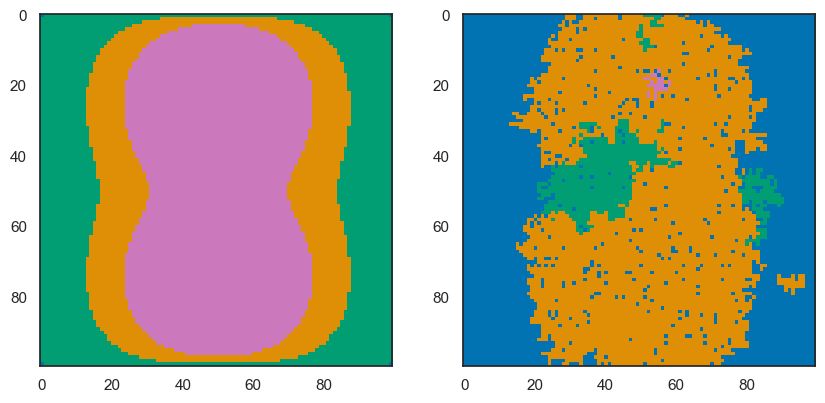

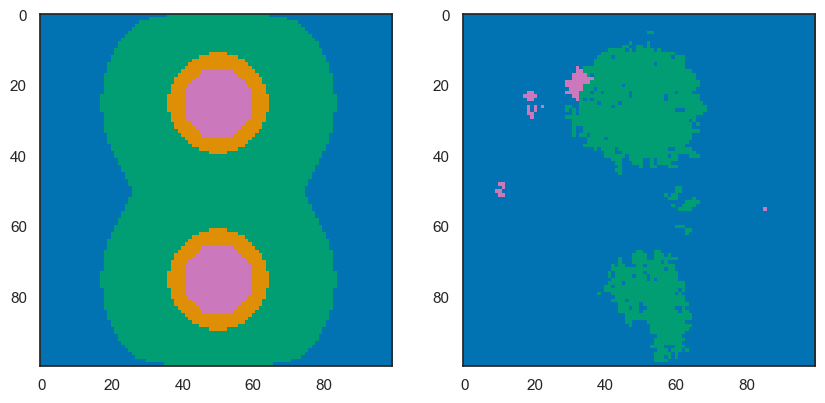

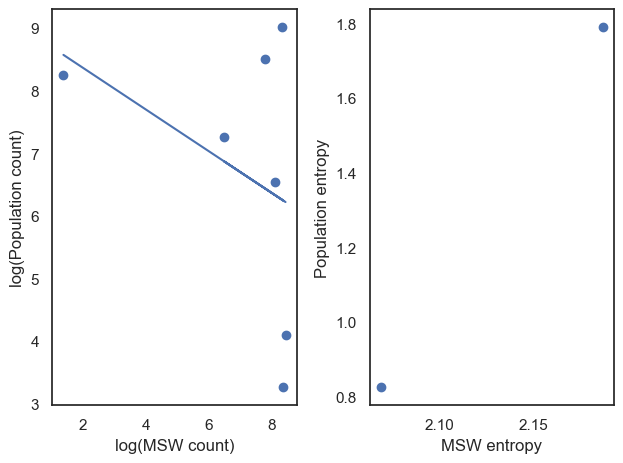

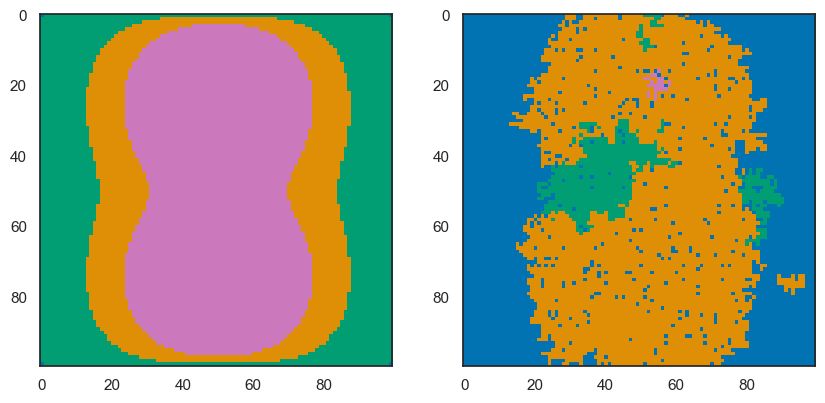

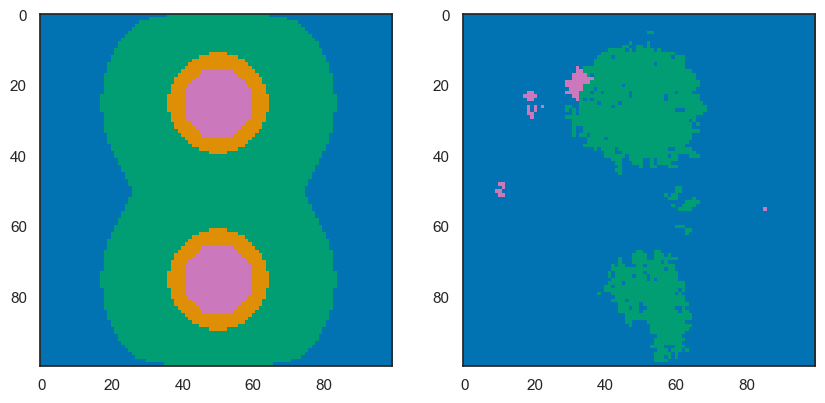

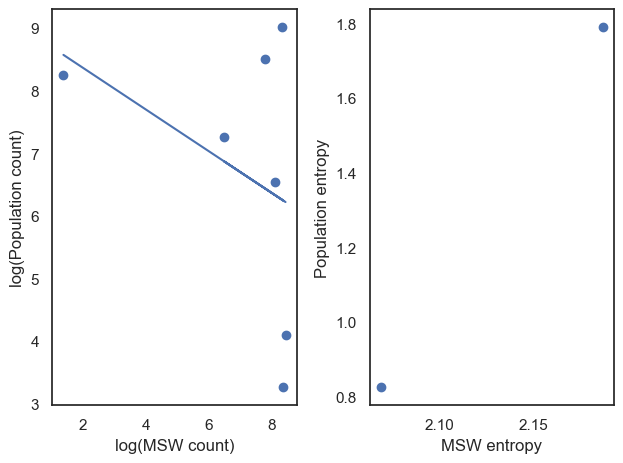

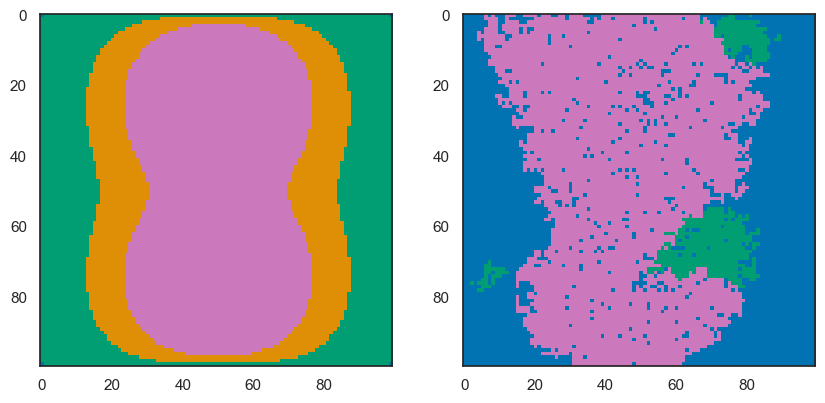

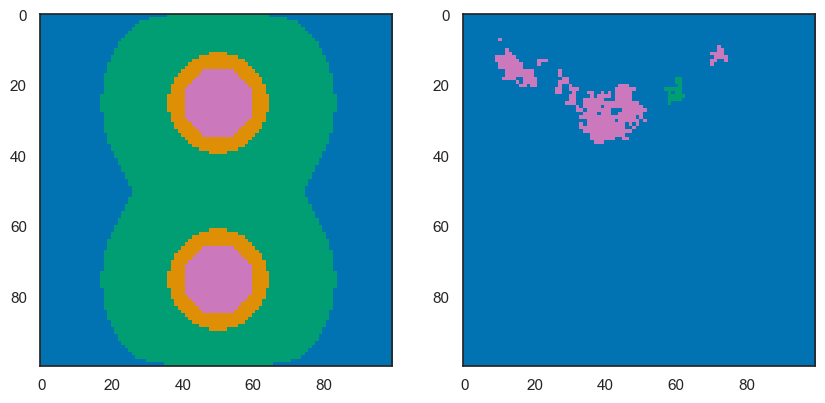

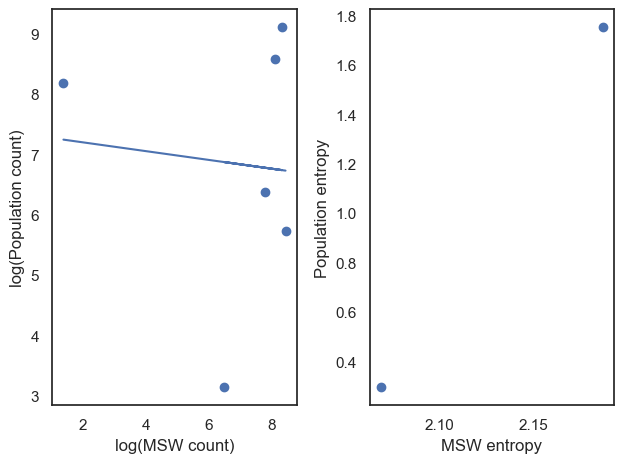

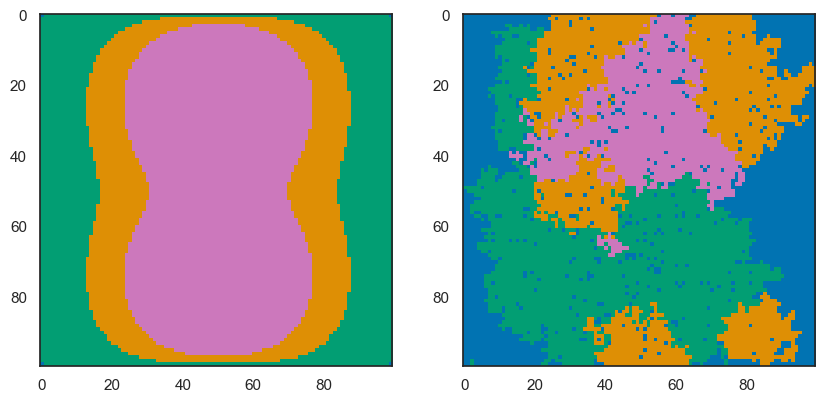

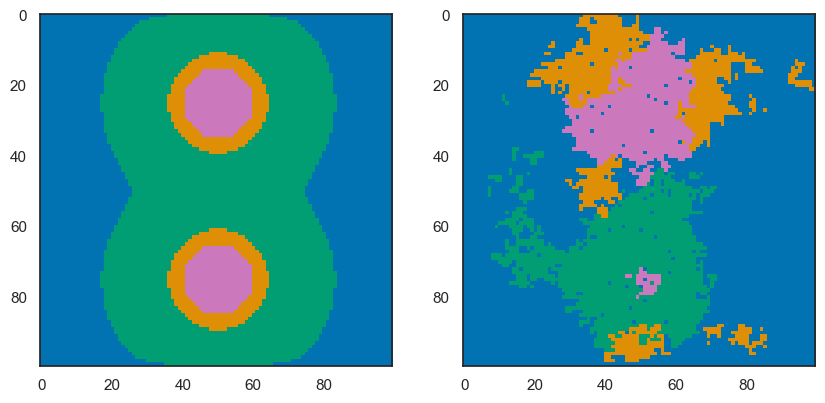

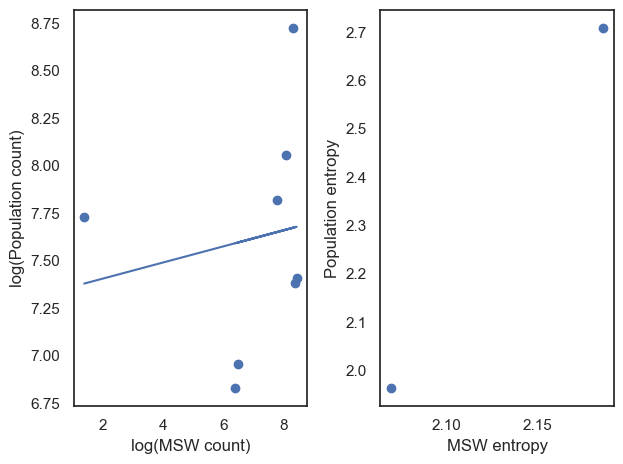

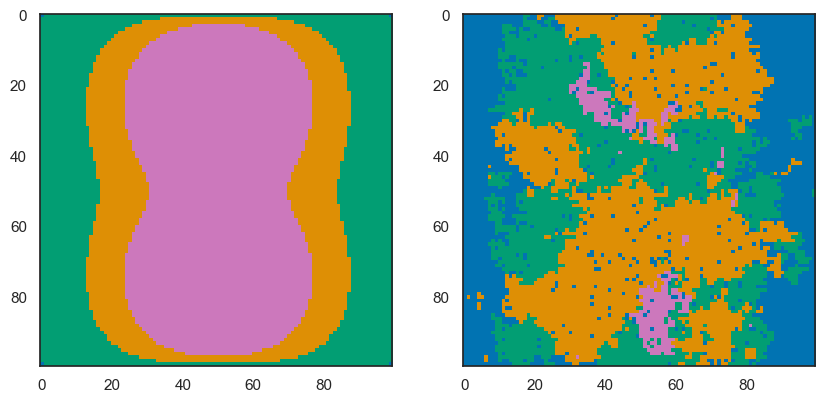

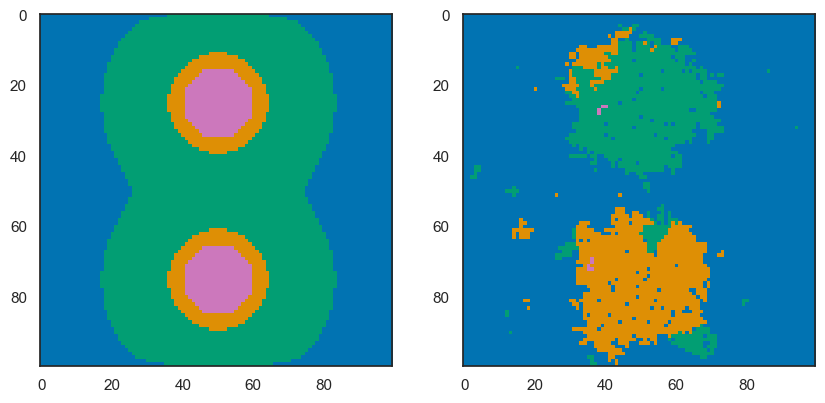

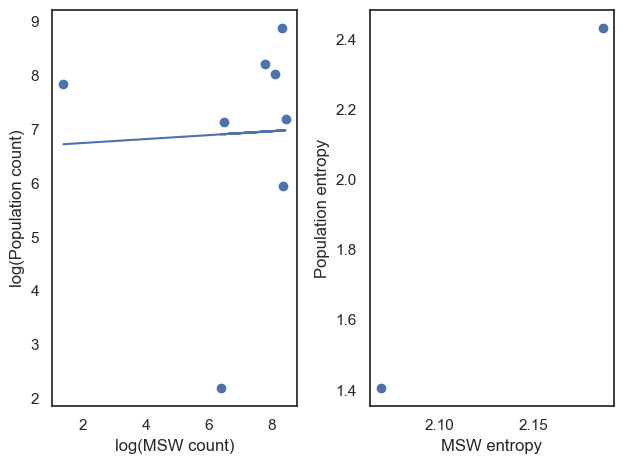

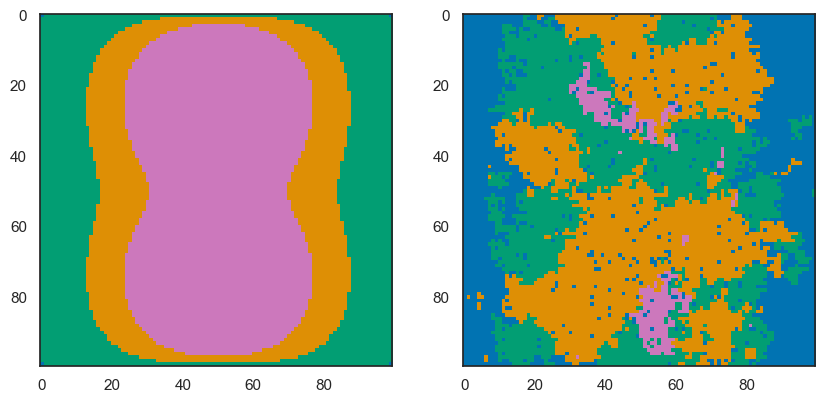

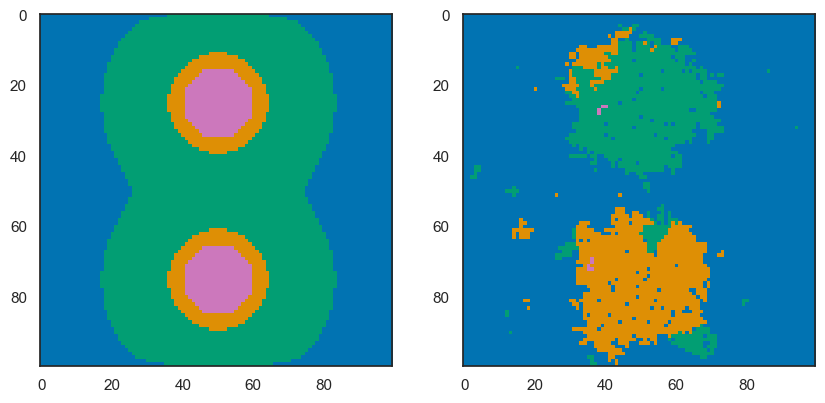

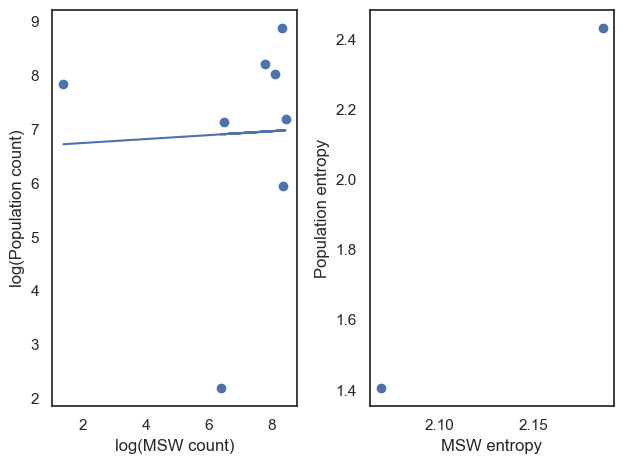

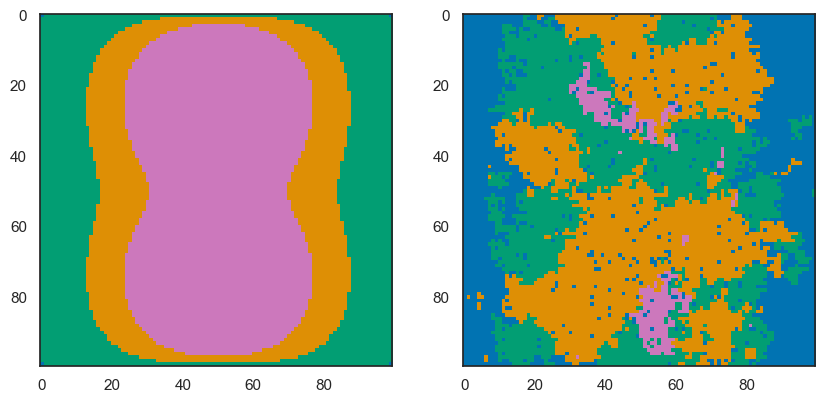

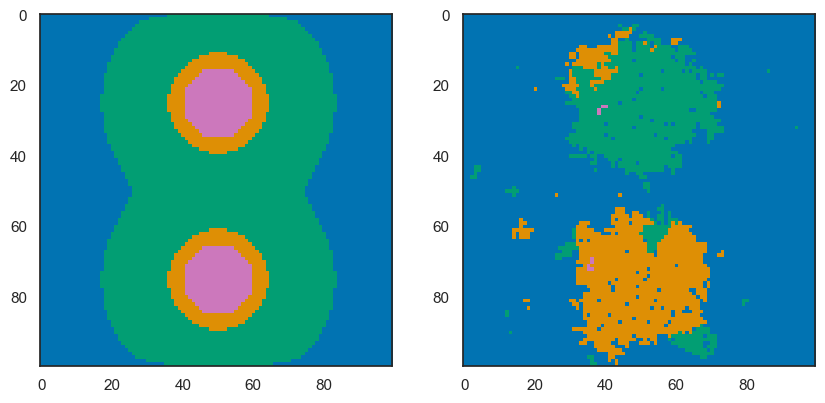

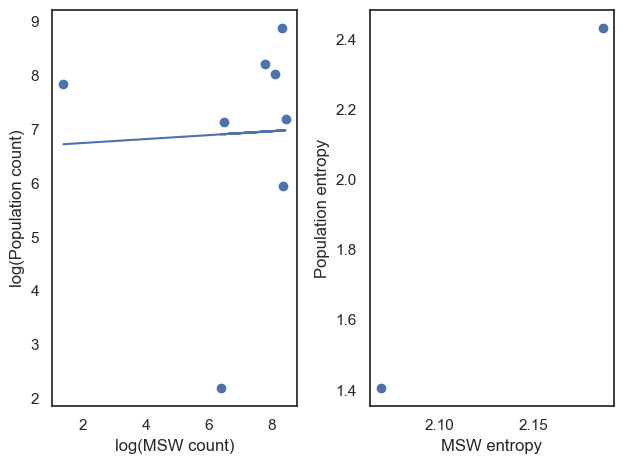

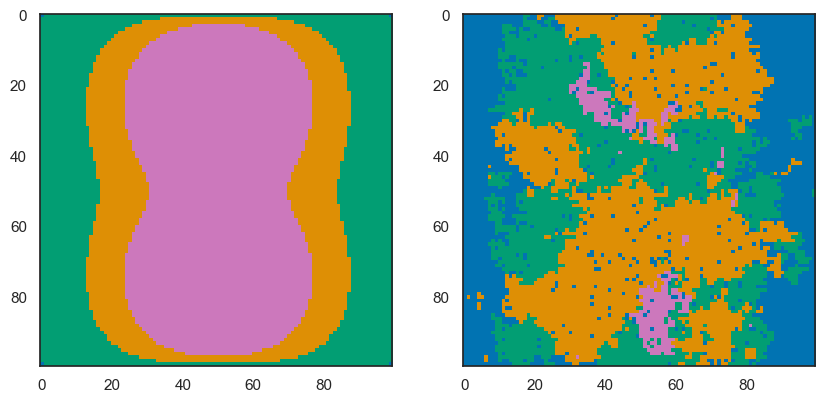

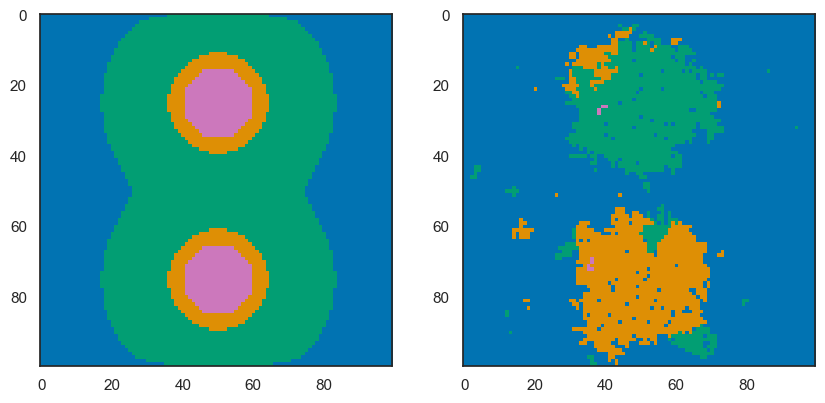

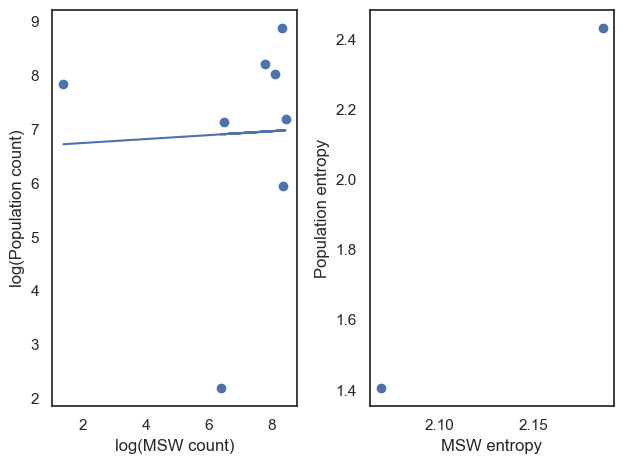

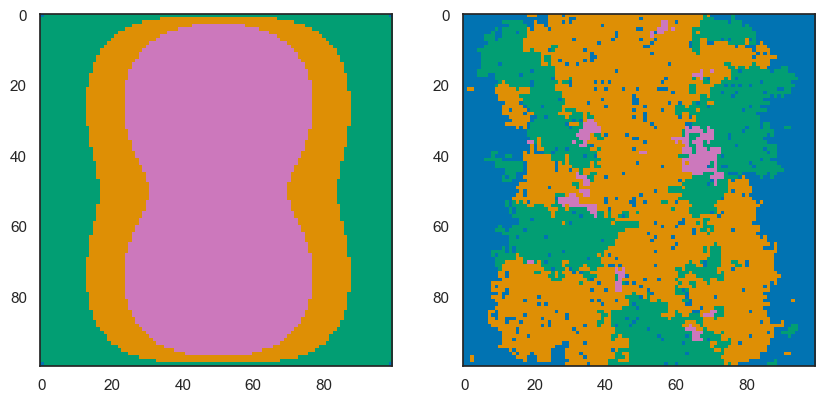

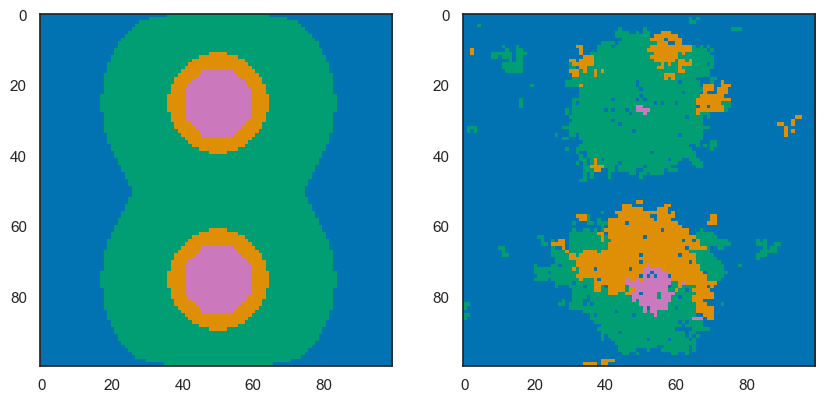

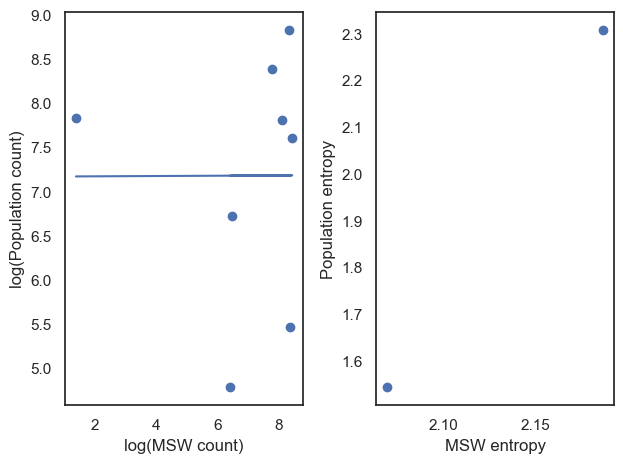

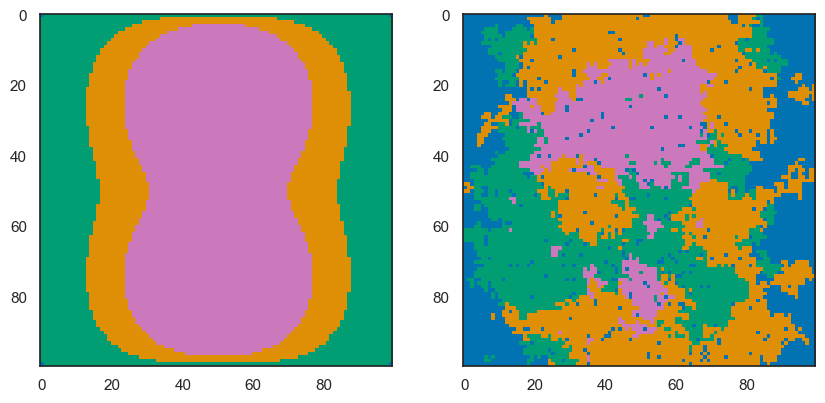

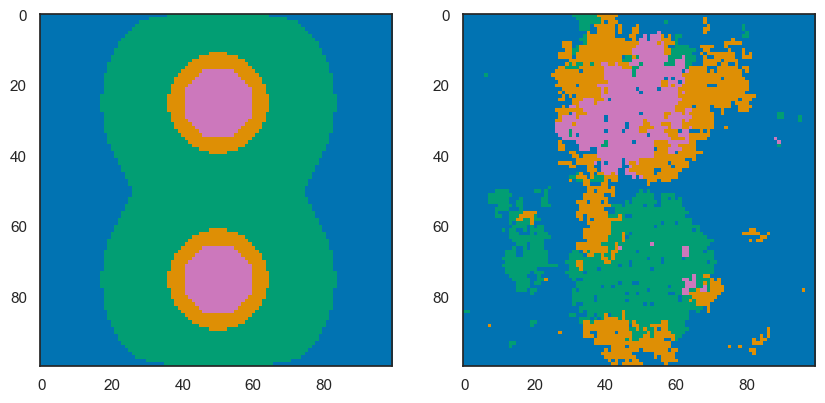

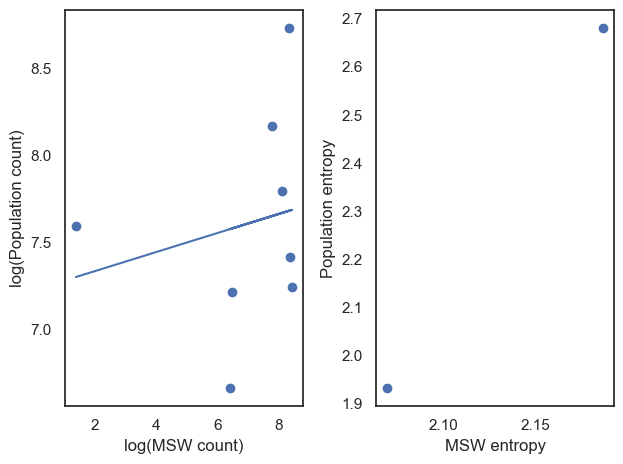

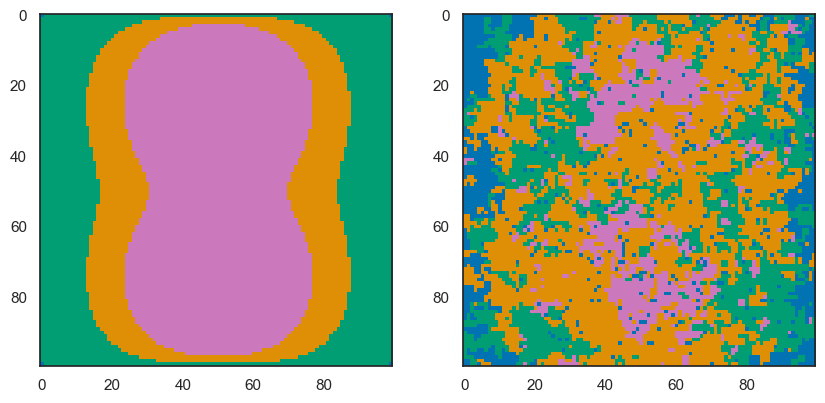

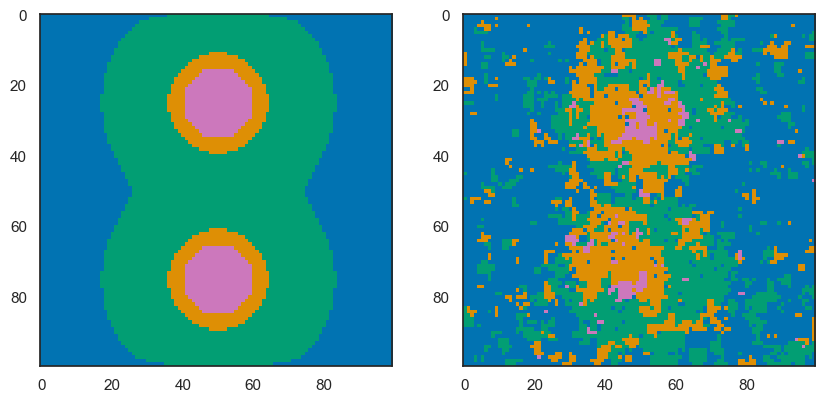

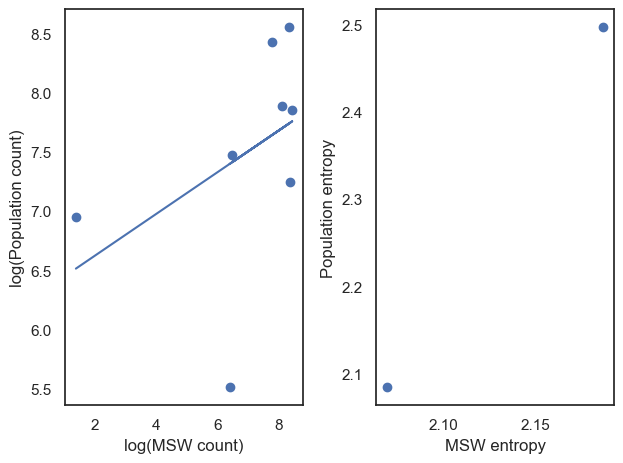

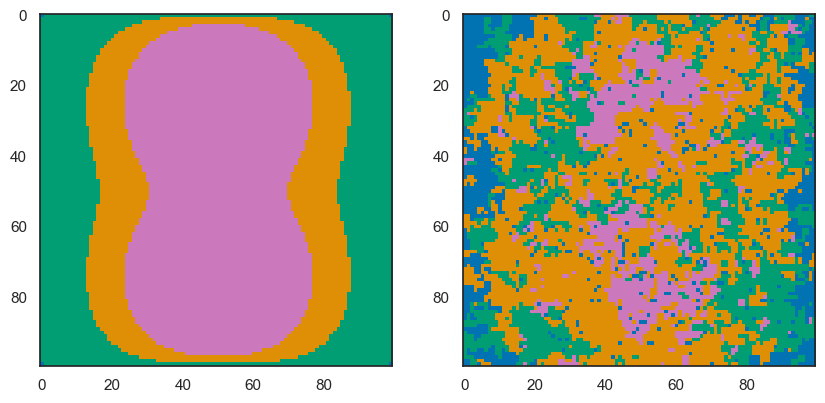

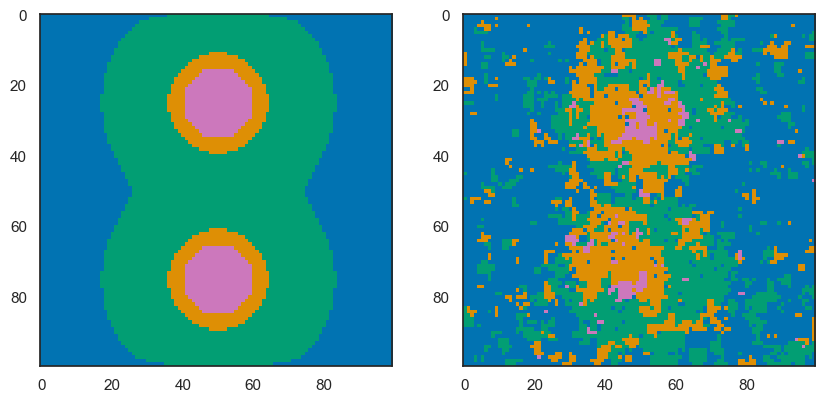

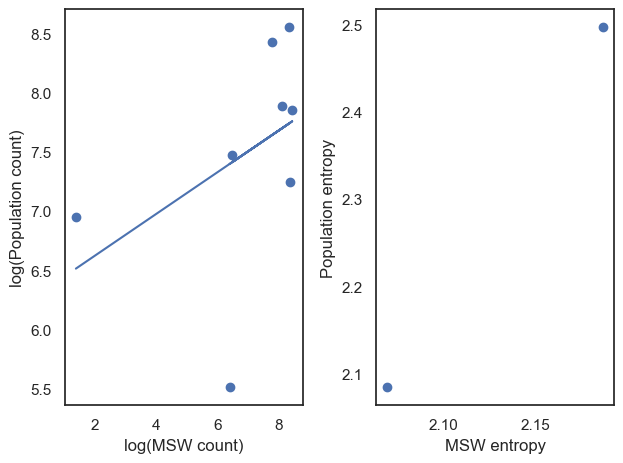

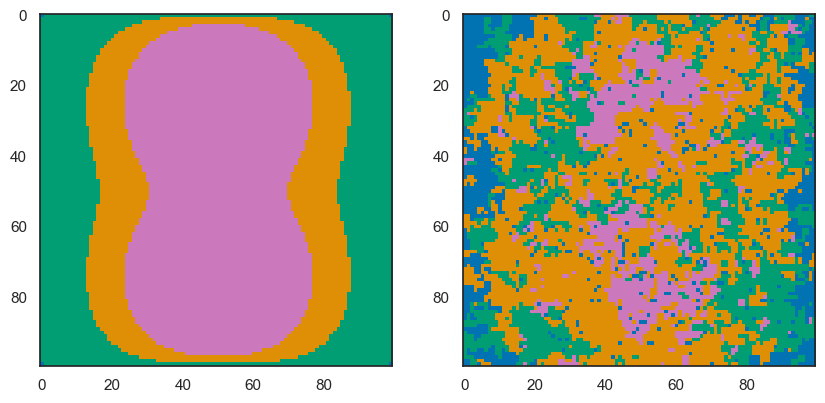

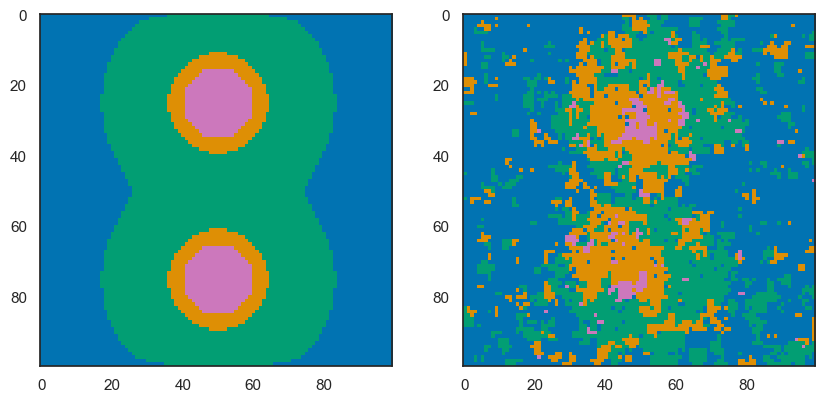

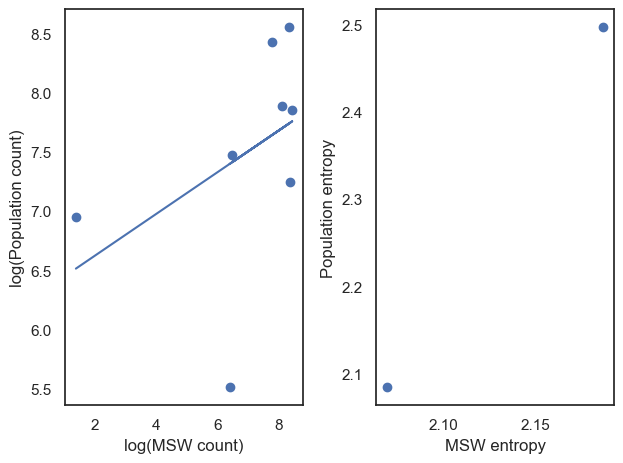

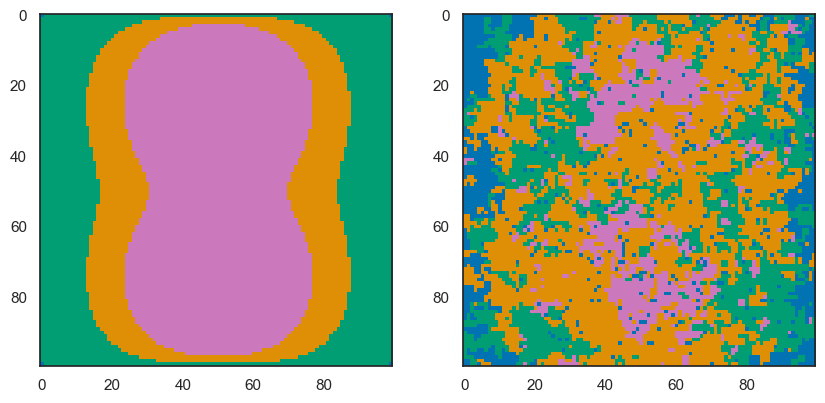

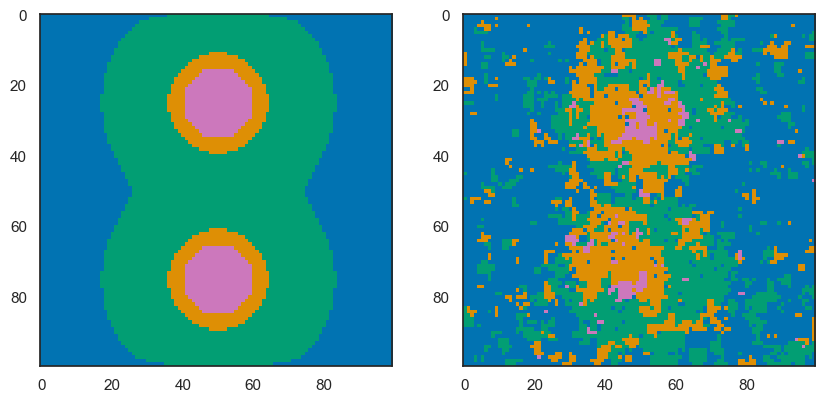

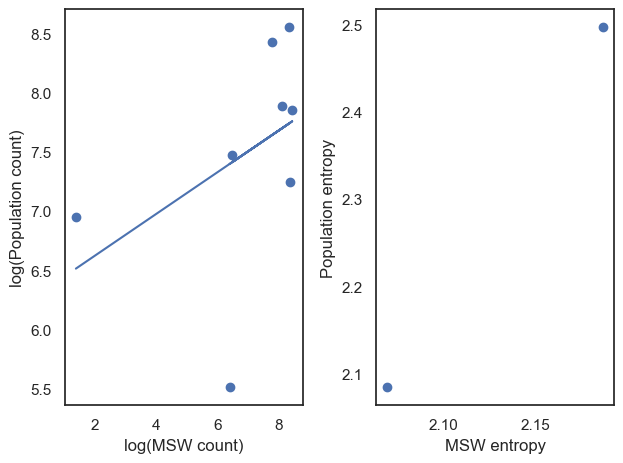

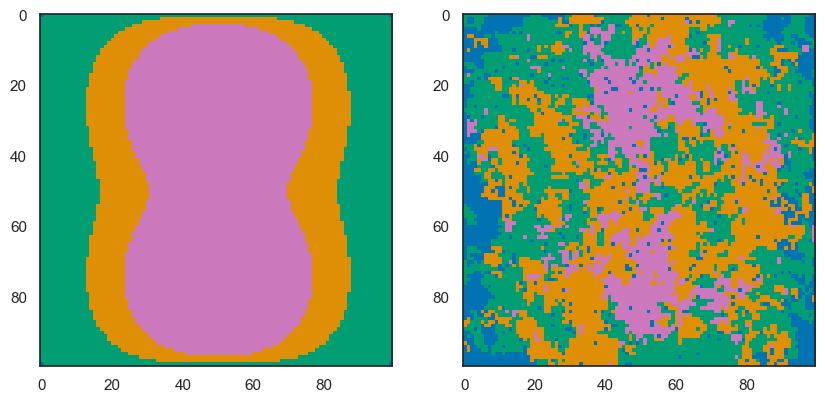

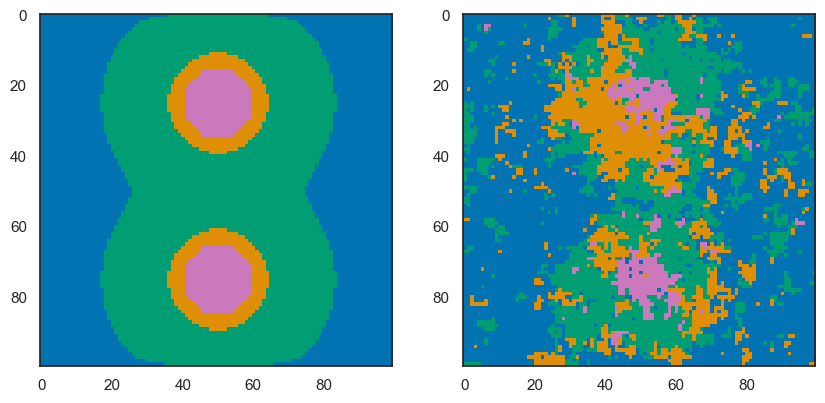

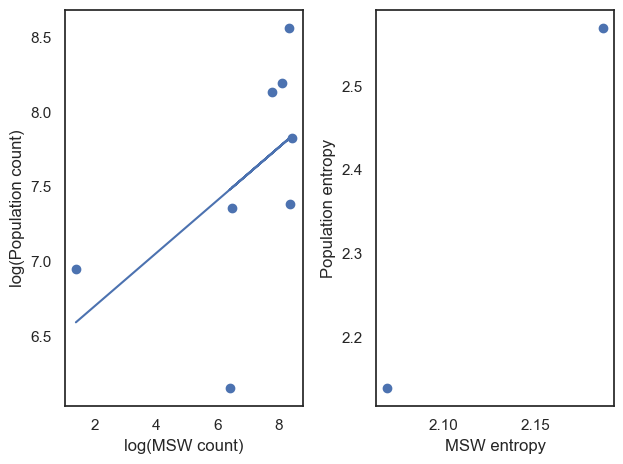

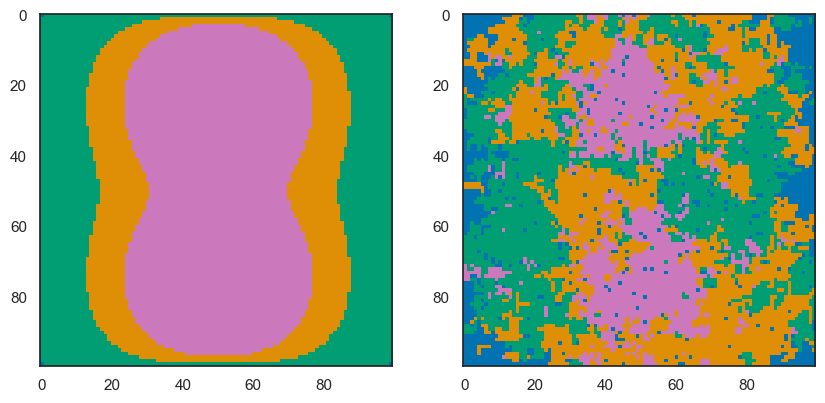

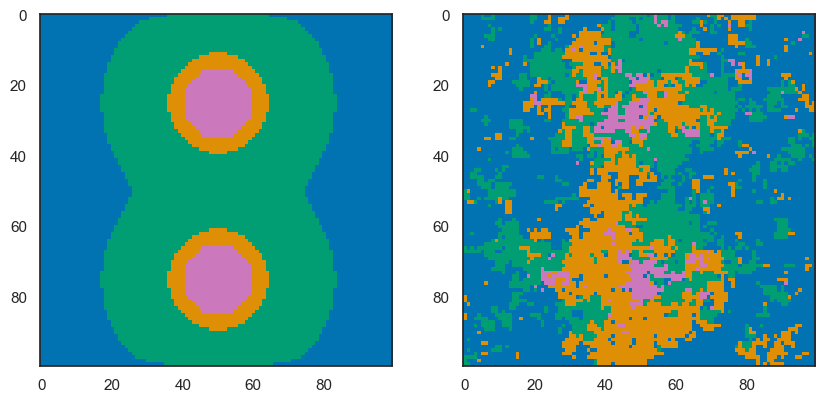

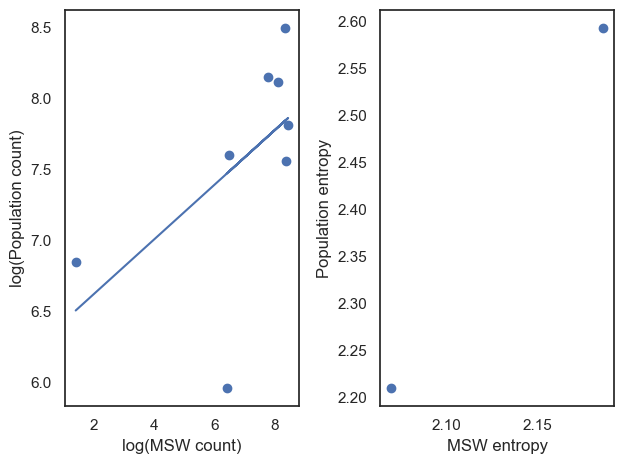

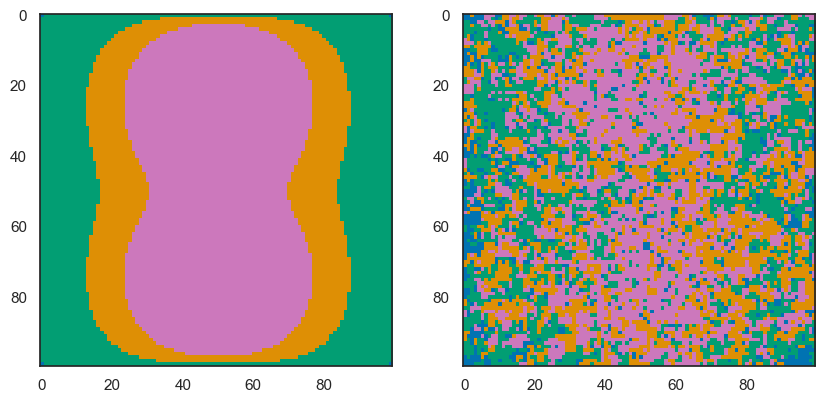

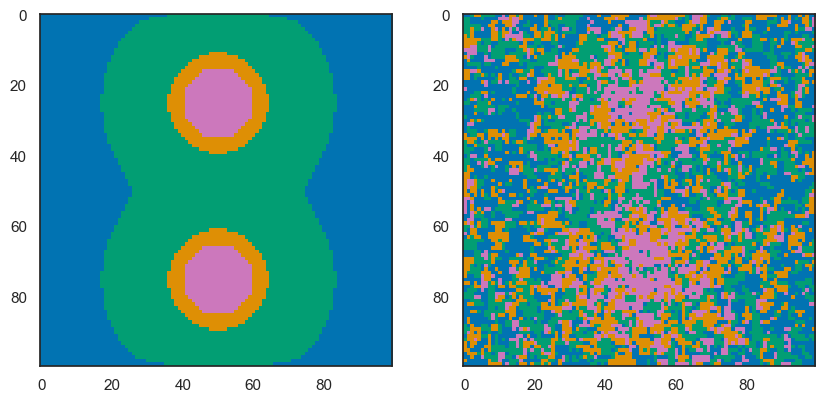

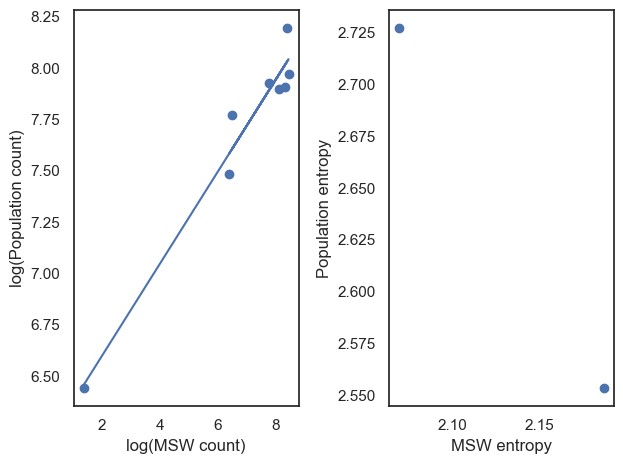

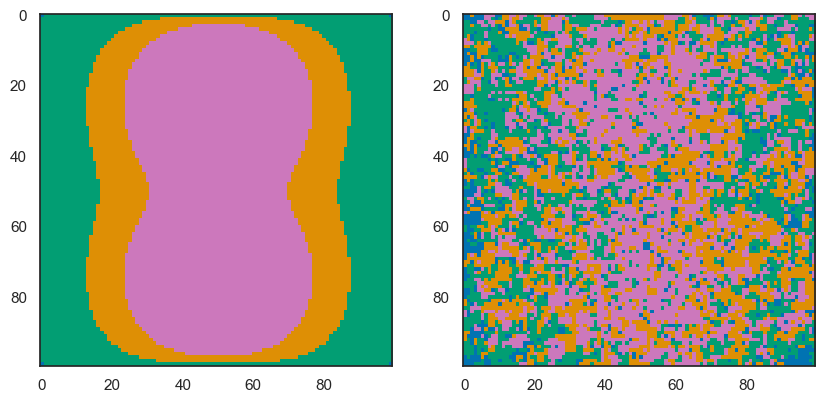

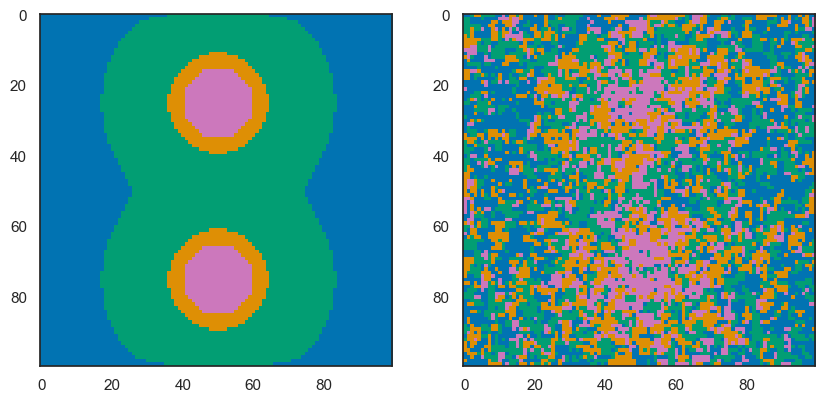

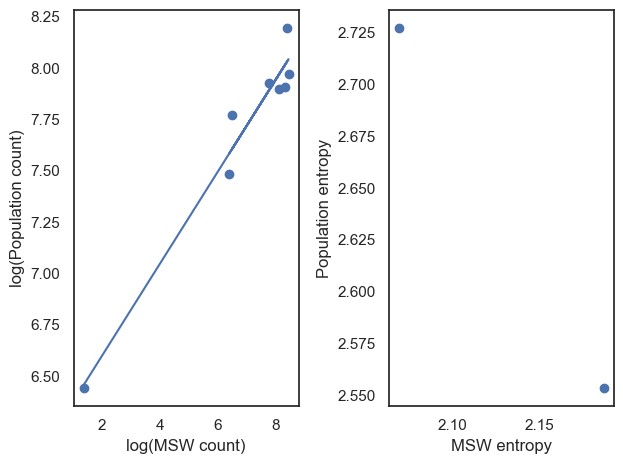

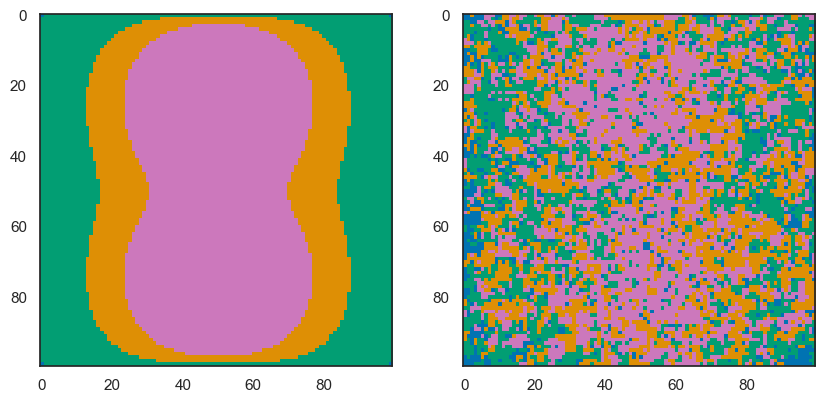

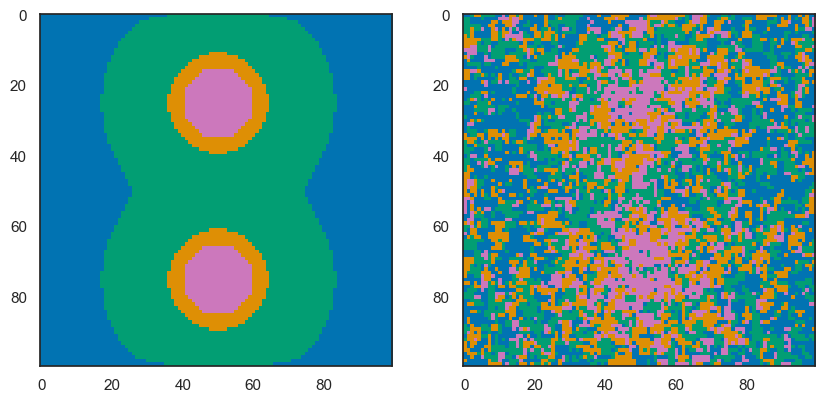

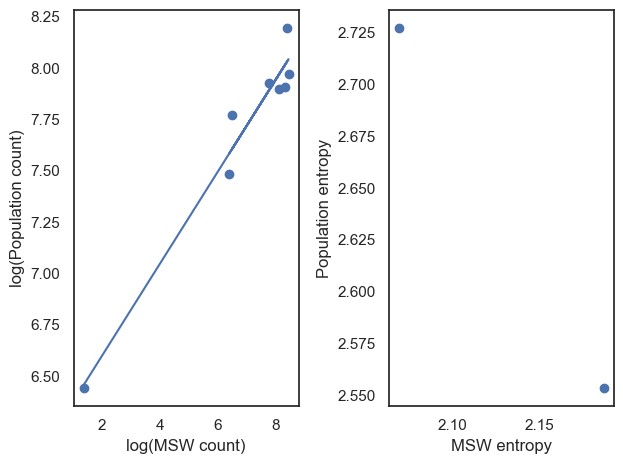

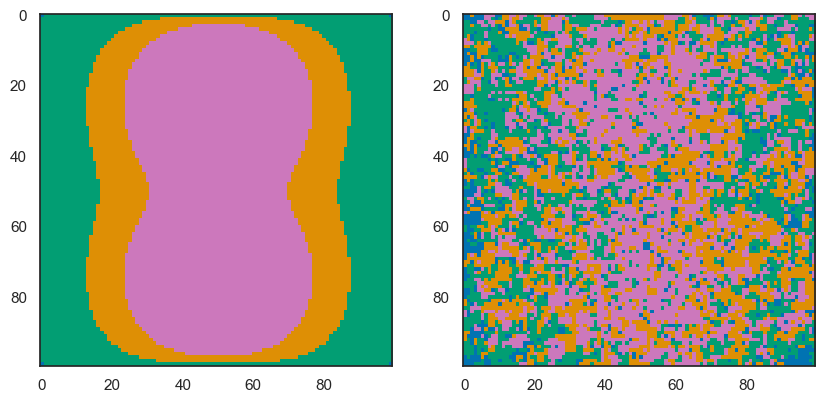

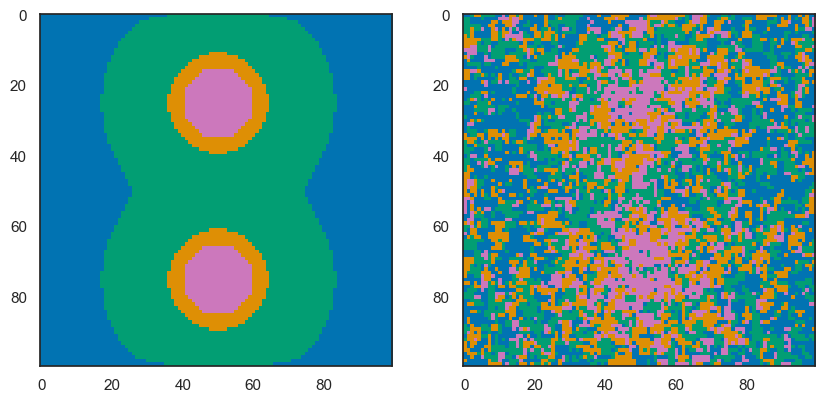

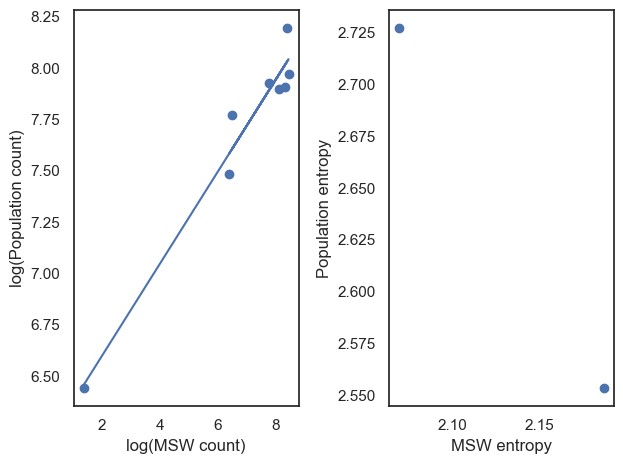

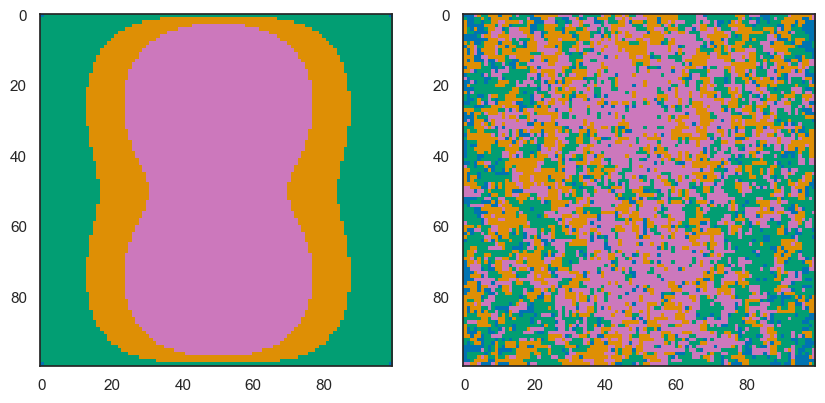

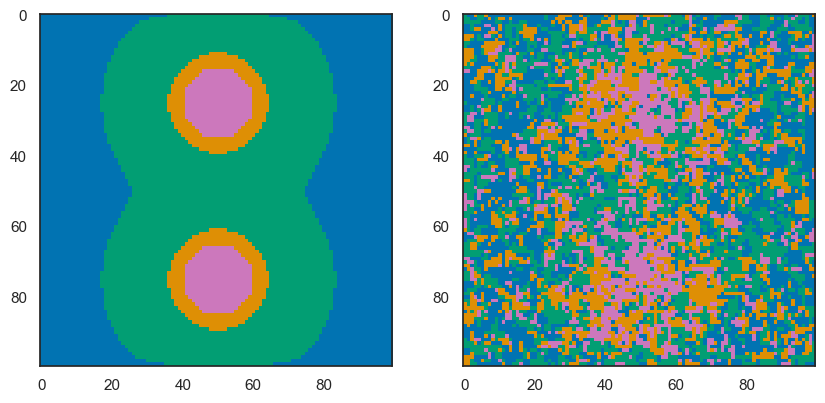

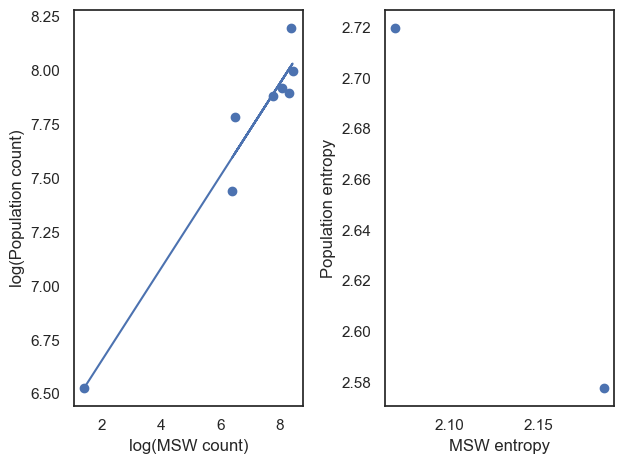

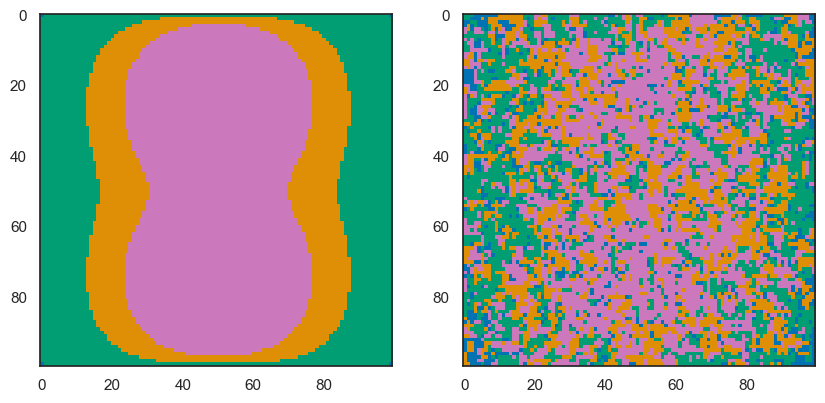

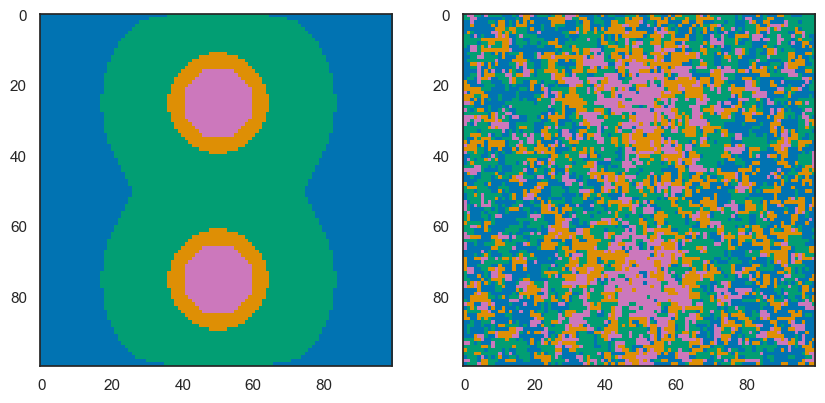

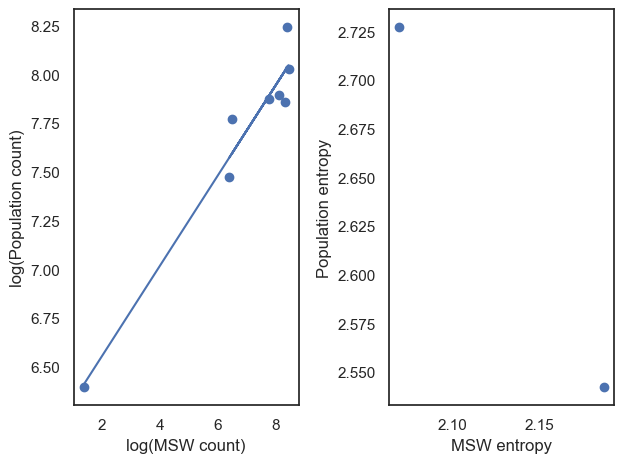

In [43]:
# setup parameter sweep

# mutation_rates = np.logspace(-5, -1, 5)
# mutation_rates = np.append(mutation_rates, 0.0)
mutation_rates = np.logspace(-5, -1, 5)
# mutation_rates = [0.001]
mutation_rates = np.append(0,mutation_rates)

init_mutant = np.logspace(-5, -1, 5)
init_mutant = np.append(0,init_mutant)

# consumpt_rate = [10**-4,0.001,0.01,0.1]
consumpt_rate = [0.001,0.01]

n_replicates = 1

jarFileName = "./HAL_dose_response.jar"
imgDir = "./tmp/"
today = date.today()
date_str = today.strftime("%Y-%m-%d")
data_folder = "./data/sensitivity_analysis_" + date_str

modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':2000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":None,
                    "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True}

total_sims = len(mutation_rates)*len(init_mutant)*len(consumpt_rate)*n_replicates
sim_count = 0

entropy_res_dict = {}
area_res_dict = {}

for r_m in mutation_rates:
    for i_m in init_mutant:
        indx = 0
        # st = time.time()
        for cr in consumpt_rate:
            modelConfigDic['consumpRate'] = cr
            modelConfigDic['pMutant'] = i_m
            modelConfigDic['mutProb'] = r_m
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
            myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
            myModel.Simulate()
            indx += 1
            sim_count += 1

        ar,er = estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False)
        # print('\n')
        # res_dict[(r_m,i_m)] = ar
        entropy_res_dict[(r_m,i_m)] = er
        area_res_dict[(r_m,i_m)] = ar
        # print('Mutation rate: {}'.format(r_m))
        # print('Initial mutant: {}'.format(i_m))
        # print(er)
        # print(ar)
        # elapsed = time.time() - st
        # time_remaining = (total_sims - sim_count)*elapsed
        # print('\n')
        # print("Estimated time remaining: {} seconds".format(np.round(time_remaining)))

        

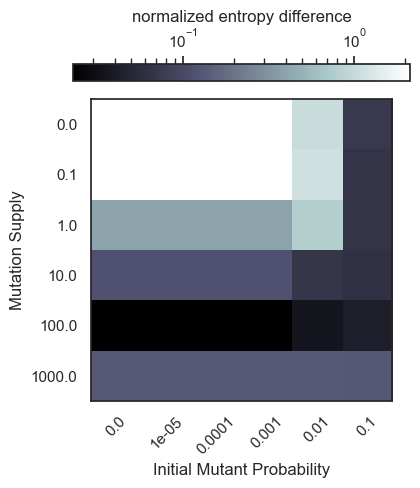

In [92]:
slope_mat = np.zeros((len(mutation_rates),len(init_mutant)))
p_mat = np.zeros((len(mutation_rates),len(init_mutant)))

# for i in range(len(mutation_rates)):
#     for j in range(len(init_mutant)):
#         r_mat[i,j] = res_dict[(mutation_rates[i],init_mutant[j])].rvalue
#         p_mat[i,j] = res_dict[(mutation_rates[i],init_mutant[j])].pvalue
for key in entropy_res_dict.keys():
    mut_indx = np.argwhere(np.array(mutation_rates) == key[0])[0][0]
    init_indx = np.argwhere(np.array(init_mutant) == key[1])[0][0]
    slope_mat[mut_indx,init_indx] = entropy_res_dict[key]
    # p_mat[mut_indx,init_indx] = entropy_res_dict[key]

# fig,ax_list = plt.subplots(ncols=2,figsize=(9,5))

# ax = ax_list[0]

# slope_mat_log = np.log10(slope_mat)

fig,ax = plt.subplots(figsize=(6,5))

# im0 = ax.imshow(slope_mat_log,cmap='viridis_r')

# ax =  ax_list[1]
norm = colors.LogNorm(vmin=slope_mat.min(), vmax=slope_mat.max())
im = ax.imshow(slope_mat,cmap='bone',norm=norm)
# im1 = ax_list[1].imshow(p_mat)
# for ax in ax_list:
ax.set_xticks(np.arange(len(init_mutant)))
ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(mutation_rates)))
mutation_supply = np.array(mutation_rates)*10**4
ax.set_yticklabels(mutation_supply)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Mutation Supply')

# make colorbars
fig.colorbar(im,ax=ax,shrink=0.6,label='normalized entropy difference',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.7,label='normalized error',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.5)

fig.tight_layout()
fig.savefig('figures/sensitivity_analysis.png',dpi=300)
